In [1]:
#%load_ext autoreload
#%autoreload 2

import h5py  
import torch
import numpy as np
from torch.utils import data
import json
from sklearn.preprocessing import normalize
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import pandemic as pan
from multiprocessing import Pool
from data_tools import hdf5Dataset_init,normalize_sets,Emulator
from scipy.stats import beta
from scipy.special import gamma
import pickle
from joblib import Parallel, delayed

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
keys = ['initial_infected_fraction', 'initial_removed_fraction', 'incubation_period', 
        'serial_interval', 'symptomatic_fraction', 'recovery_days', 'quarantine_days', 
        'days_indetectable', 'R0', 'contact_rate', 'npi_factor', 'contact_tracing_testing_rate', 
        'contact_tracing_quarantine_rate', 'contact_tracing_days', 'daily_testing_fraction', 
        'daily_testing_false_positive', 'daily_testing_false_negative', 'class_size_limit', 
        'contact_upscale_factor', 'friendship_contacts', 'academic_contacts', 'broad_social_contacts', 
        'department_environmental_contacts', 'broad_environmental_contacts', 'residential_neighbors', 
        'online_transition']

keys_to_round = ['incubation_period', 'serial_interval', 'recovery_days',
                 'quarantine_days', 'days_indetectable', 'contact_tracing_days',
                 'class_size_limit', 'friendship_contacts', 'academic_contacts',
                 'broad_social_contacts', 'department_environmental_contacts',
                 'broad_environmental_contacts', 'residential_neighbors', 'online_transition']

In [2]:
initset = hdf5Dataset_init('full_data.hdf5')   
training, testing = initset.split_datasets(.1,split_type='parameter')
training_,testing_,X_mean,X_std = normalize_sets(training,testing)

In [2]:
data = pd.read_csv('datasets/testing.csv',skiprows=9)
active = pd.read_csv('datasets/active.csv',skiprows=1)
av = active.values[7:,2]
r = np.linspace(0,len(av)-1,len(av))
dd = np.vstack((r,av)).T
ac = dd[np.invert(np.isnan(dd[:,1].astype(float)))]

rapid_pcr_tests = np.nan_to_num(data.values[79:,2].astype(float))
rapid_pcr_pos = np.nan_to_num(data.values[79:,4].astype(float))
rapid_antigen_tests = np.nan_to_num(data.values[79:,3].astype(float))
rapid_antigen_pos = np.nan_to_num(data.values[79:,5].astype(float))
state_tests = np.nan_to_num(data.values[79:,6].astype(float))
state_pos = np.nan_to_num(data.values[79:,8].astype(float))

total_tests = rapid_pcr_tests + rapid_antigen_tests + state_tests
total_pos = rapid_pcr_pos + rapid_antigen_pos + state_pos
cum_tests = np.cumsum(total_tests)
cum_pos = np.cumsum(total_pos)
n_data = 194 - 90

test_obs = torch.tensor(cum_tests,dtype=torch.float,device=device)[:n_data]
pos_obs = torch.tensor(cum_pos,dtype=torch.float,device=device)[:n_data]

In [4]:
alpha_b = 3
beta_b = 3

X = torch.stack([t[0] for t in training_])

X_min = X.cpu().numpy().min(axis=0)-1e-3
X_max = X.cpu().numpy().max(axis=0)+1e-3

X_min = torch.tensor(X_min,dtype=torch.float32,device=device)
X_max = torch.tensor(X_max,dtype=torch.float32,device=device)

In [5]:
alpha = 0.1
sigma_tes = 100
sigma_pos = 10
nu = 1.

time = torch.linspace(1,n_data,n_data,device=device)
def V(X):
    _pred = 2**model(X) - 1.

    test_pred = _pred[:n_data,2]
    pos_pred = _pred[:n_data,1]
    
    r_test = (test_pred - test_obs)
    r_pos = (pos_pred - pos_obs)
    X_bar = (X - X_min)/(X_max - X_min)

    sigma_tes_t = torch.sqrt(time)*sigma_tes
    sigma_pos_t = torch.sqrt(time)*sigma_pos

    L1a = torch.sum(np.log(gamma((nu+1)/2.)) - np.log(gamma(nu/2.)) - torch.log(np.sqrt(np.pi*nu)*sigma_tes_t) - (nu+1)/2.*torch.log(1 + 1./nu*(r_test**2/sigma_tes_t**2)))
    L1b = torch.sum(np.log(gamma((nu+1)/2.)) - np.log(gamma(nu/2.)) - torch.log(np.sqrt(np.pi*nu)*sigma_pos_t) - (nu+1)/2.*torch.log(1 + 1./nu*(r_pos**2/sigma_pos_t**2)))
    L2 = torch.sum((alpha_b-1)*torch.log(X_bar) + (beta_b-1)*torch.log(1-X_bar)) 

    return -(alpha*(L1a + L1b) + L2)

def V_empirical(X,Y):
    _pred = Y
    #print(_pred)

    test_pred = _pred[:n_data,2]
    pos_pred = _pred[:n_data,1]
    #print(U_pred.min())
    r_test = (test_pred - test_obs)
    r_pos = (pos_pred - pos_obs)
    X_bar = (X - X_min)/(X_max - X_min)
    sigma_tes_t = torch.sqrt(time)*sigma_tes
    sigma_pos_t = torch.sqrt(time)*sigma_pos

    L1a = torch.sum(np.log(gamma((nu+1)/2.)) - np.log(gamma(nu/2.)) - torch.log(np.sqrt(np.pi*nu)*sigma_tes_t) - (nu+1)/2.*torch.log(1 + 1./nu*(r_test**2/sigma_tes_t**2)))
    L1b = torch.sum(np.log(gamma((nu+1)/2.)) - np.log(gamma(nu/2.)) - torch.log(np.sqrt(np.pi*nu)*sigma_pos_t) - (nu+1)/2.*torch.log(1 + 1./nu*(r_pos**2/sigma_pos_t**2)))
    L2 = torch.sum((alpha_b-1)*torch.log(X_bar) + (beta_b-1)*torch.log(1-X_bar)) 


    return -(alpha*(L1a + L1b) + L2)

def get_log_like_gradient_and_hessian(V,X,eps=1e-2,compute_hessian=False):
    log_pi = V(X)
    if compute_hessian:
        g = torch.autograd.grad(log_pi,X,retain_graph=True,create_graph=True)[0]
        H = torch.stack([torch.autograd.grad(e,X,retain_graph=True)[0] for e in g])
        lamda,Q = torch.eig(H,eigenvectors=True)
        lamda_prime = torch.sqrt(lamda[:,0]**2 + eps)
        lamda_prime_inv = 1./torch.sqrt(lamda[:,0]**2 + eps)
        H = Q @ torch.diag(lamda_prime) @ Q.T
        Hinv = Q @ torch.diag(lamda_prime_inv) @ Q.T
        log_det_Hinv = torch.sum(torch.log(lamda_prime_inv))
        return log_pi,g,H,Hinv,log_det_Hinv
    else: 
        return log_pi

In [6]:
model = Emulator()
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def train_model(model,training_,testing_,epochs=200,batch_size=256,weight_factor=50.):
    V_vals = torch.stack([V_empirical(x,y.T) for x,y in zip(training_.tensors[0],training_.tensors[1])])

    w = torch.exp(-V_vals/weight_factor)
    w/=w.sum()


    train_weights = TensorDataset(training_.tensors[0],training_.tensors[1],w)

    train_loader = torch.utils.data.DataLoader(dataset=train_weights,
                                           batch_size=batch_size, 
                                           shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=testing_,
                                           batch_size=batch_size, 
                                           shuffle=False)

    for epoch in range(epochs):
        model.train()
        # Loop over each subset of data
        for d,t,w in train_loader:
        
            t = torch.log2(t+1.)

            # Zero out the optimizer's gradient buffer+
            optimizer.zero_grad()
            # Make a prediction based on the model

            outputs = model(d)

            # Compute the loss+
        
            #standardize the output first
            loss = 0
            residual_squared = (outputs - t)**2
            for ww,r in zip(w,residual_squared):
                loss += torch.sum(ww*r)
                
            #print('d',d.min(),d.max())
            #print('outputs',outputs.min(),outputs.max())
            #print('t',t.min(),t.max())
            #print('loss',loss)
        
            loss.backward()

            # Use the derivative information to update the parameters
            optimizer.step()
    
        model.eval()
        
        if epoch %50 == 0:
            training_loss = criterion(model(training_.tensors[0]),torch.log2(training_.tensors[1]+1))
            test_loss = criterion(model(testing_.tensors[0]),torch.log2(testing_.tensors[1]+1))
            print('finished epoch {}'.format(epoch))
            print('loss', training_loss.item(), test_loss.item())
            print('*'*50)
    
    print('finished training') 

In [8]:
def draw_sample(mu,cov,eps=1e-10):
    L = torch.cholesky(cov + eps*torch.eye(cov.shape[0],device=device))
    return mu + L @ torch.randn(L.shape[0],device=device)

def get_proposal_likelihood(Y,mu,inverse_cov,log_det_cov):
    return -0.5*log_det_cov - 0.5*(Y - mu) @ inverse_cov @ (Y-mu)

def MALA_step(X,h,local_data=None):
    if local_data is not None:
        pass  
    else:
        local_data = get_log_like_gradient_and_hessian(V,X,compute_hessian=True)
        
    log_pi,g,H,Hinv,log_det_Hinv = local_data
    
    X_ = draw_sample(X,2*h*Hinv).detach()
    #X_0[0] = X_0[0].round()
    #X_0[1] = X_0[1].round()
    #X_0[-1] = X_0[-1].round()
    X_.requires_grad=True
    
    log_pi_ = get_log_like_gradient_and_hessian(V,X_,compute_hessian=False)

    logq = get_proposal_likelihood(X_,X,H/(2*h),log_det_Hinv)
    logq_ = get_proposal_likelihood(X,X_,H/(2*h),log_det_Hinv)

    log_alpha = (-log_pi_ + logq_ + log_pi - logq)
    alpha = torch.exp(min(log_alpha,torch.tensor([0.],device=device)))
    u = torch.rand(1,device=device)
    if u <= alpha and log_alpha!=np.inf:
        X.data = X_.data
        log_pi_new = get_log_like_gradient_and_hessian(V,X,compute_hessian=False)
        local_data[0].data = log_pi_new.data# = get_log_like_gradient_and_hessian(V,X,compute_hessian=True)
        s = 1
    else:
        s = 0
    return X,local_data,s,local_data[0]

def MALA(X,n_iters=10001,h=0.001,h_max=1.0,acc_target=0.25,k=0.01,beta=0.99,sample_path='./samples/',model_index=0,save_interval=1000,print_interval=50):
    print('***********************************************')
    print('***********************************************')
    print('Running Metropolis-Adjusted Langevin Algorithm for model index {0}'.format(model_index))
    print('***********************************************')
    print('***********************************************')
    local_data = None
    vars = []
    log_pis = []
    acc = acc_target
    for i in range(n_iters):
        X,local_data,s,log_pi = MALA_step(X,h,local_data=local_data)
        vars.append(X.detach())
        log_pis.append(log_pi.detach())
        acc = beta*acc + (1-beta)*s
        h = min(h*(1+k*np.sign(acc - acc_target)),h_max)
        if i%print_interval==0:
            print('===============================================')
            print('sample: {0:d}, acc. rate: {1:4.2f}, log(P): {2:6.1f}'.format(i,acc,local_data[0].item()))
            print('curr. m: '+('{:.4f} '*26).format(*X.data.cpu().numpy()))
            print('===============================================')
          
        #if i%save_interval==0:
        #    print('///////////////////////////////////////////////')
        #    print('Saving samples for model {0:03d}'.format(model_index))
        #    print('///////////////////////////////////////////////')
        #    X_posterior = torch.stack(vars).cpu().numpy()
        #    np.save(open(sample_path+'X_posterior_model_{0:03d}.npy'.format(model_index),'wb'),X_posterior)
    X_posterior = torch.stack(vars)#.cpu().numpy()
    pi_posterior = torch.stack(log_pis)
    return X_posterior,pi_posterior 

In [14]:
def run_abm(run_input):
    run_index,parameters = run_input
    sample = dict(zip(keys,parameters))
    for k in keys_to_round:
        sample[k] = int(np.round(sample[k]))

    sample['scenario_name'] = 'trial_'+str(run_index)
    sample['quarantining'] = 1
    sample['social_distancing'] = 1
    sample['contact_tracing'] = 1

    pandemic = pan.Disease(sample)
    pandemic.multiple_runs(5,recorder)

In [10]:
n_abm_samples = 20
for i in range(0,20):
    print('iteration '+str(i))
    model = Emulator()
    model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_model(model,training_,testing_,epochs=500)
    torch.save(model.state_dict(),'iterative_models/trained_{:03d}.h5'.format(i))
    objs = torch.stack([V(X_) for X_ in X])
    X_0 = torch.tensor(X[torch.argmin(objs)],requires_grad=True,dtype=torch.float,device=device)
    X_posterior,pi_posterior = MALA(X_0,n_iters=5001,model_index=0,save_interval=1000,print_interval=100)
    X_p_numpy = (X_posterior*X_std + X_mean).detach().cpu().numpy().astype(np.float64)
    pickle.dump(X_p_numpy,open('mcmc_samples/sample_{:03d}.p'.format(i),'wb'))
    recorder = pan.analysis.recorder(['tests_performed_total', 'positive_tests_total', 'active_cases'], 
                                     'abm_results/runs_{:03d}.hdf5'.format(i))
    
    samples = X_p_numpy[np.random.choice(range(1000,X_p_numpy.shape[0]),n_abm_samples,replace=False)]
    try:
        Parallel(n_jobs=4)(delayed(run_abm)(x) for x in enumerate(samples))
        newset = hdf5Dataset_init('abm_results/runs_{:03d}.hdf5'.format(i))   
        train_new, test_new = newset.split_datasets(.1,split_type='parameter')
        train_new_,test_new_,_,_ = normalize_sets(train_new,test_new,X_mean=X_mean,X_std=X_std)
        training_ = TensorDataset(torch.cat((training_.tensors[0],train_new_.tensors[0])),torch.cat((training_.tensors[1],train_new_.tensors[1])))
        testing_ = TensorDataset(torch.cat((testing_.tensors[0],test_new_.tensors[0])),torch.cat((testing_.tensors[1],test_new_.tensors[1])))

        X = torch.stack([t[0] for t in training_])
        X_min = X.cpu().numpy().min(axis=0)-1e-3
        X_max = X.cpu().numpy().max(axis=0)+1e-3
        X_min = torch.tensor(X_min,dtype=torch.float32,device=device)
        X_max = torch.tensor(X_max,dtype=torch.float32,device=device)
    except KeyError:
        pass

iteration 0
finished epoch 0
loss 45.344482421875 41.83647155761719
**************************************************
finished epoch 50
loss 0.9364824295043945 1.5922257900238037
**************************************************
finished epoch 100
loss 0.40182897448539734 1.2136504650115967
**************************************************
finished epoch 150
loss 0.2848914563655853 1.1367686986923218
**************************************************
finished epoch 200
loss 0.24163848161697388 1.1256097555160522
**************************************************
finished epoch 250
loss 0.20170769095420837 1.0854089260101318
**************************************************
finished epoch 300
loss 0.1943235844373703 1.102662205696106
**************************************************
finished epoch 350
loss 0.21735212206840515 1.1012130975723267
**************************************************
finished epoch 400
loss 0.15887004137039185 1.0663901567459106
*************************

/home/brinkerhoff/miniconda3/envs/working/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


***********************************************
***********************************************
Running Metropolis-Adjusted Langevin Algorithm for model index 0
***********************************************
***********************************************
sample: 0, acc. rate: 0.26, log(P):  218.8
curr. m: 1.0366 0.1175 -0.3601 0.0535 -1.3489 1.0198 -1.4592 0.4634 1.0078 0.7187 1.7674 -0.6034 0.1053 -0.5896 0.4242 -1.6977 -0.0033 0.1764 0.8230 0.3554 0.6461 0.6493 -0.3692 -1.0117 0.1564 -1.7795 
sample: 100, acc. rate: 0.58, log(P):  219.9
curr. m: 1.3694 0.1099 0.0975 0.1923 -0.9188 0.9790 -1.2010 -0.4924 1.0847 1.0624 1.7178 -1.0985 -0.5050 -0.7645 0.4456 -1.4925 -0.2342 0.2908 0.7750 0.8265 1.3085 0.3282 0.7643 -1.0821 0.1598 -1.5318 
sample: 200, acc. rate: 0.50, log(P):  223.2
curr. m: 0.3919 -1.3362 0.2945 -0.1298 -0.5787 0.9719 -1.0618 -0.1581 1.4320 1.2148 1.8470 -0.6020 1.0455 -0.7206 -0.1371 -1.4128 0.1259 0.5492 0.6805 0.1475 0.6857 0.7045 0.3515 -1.4958 0.2283 -1.6026 
sam

sample: 2300, acc. rate: 0.36, log(P):  217.6
curr. m: 1.1150 -0.3963 0.8834 0.3751 0.7356 0.6780 -0.4000 0.3510 0.2894 0.7037 1.1612 0.6545 -0.0528 -1.1229 1.6990 -0.4227 1.4511 -1.6447 0.0786 -0.8433 0.1158 0.8314 0.3110 1.5030 -0.1041 -0.2059 
sample: 2400, acc. rate: 0.21, log(P):  219.4
curr. m: 1.6354 0.6115 1.5705 0.5533 0.2284 0.6492 -0.2114 0.7081 1.2283 1.2640 0.9462 0.7665 -0.0131 -1.1083 1.4917 -0.1374 0.9619 -1.1768 0.2975 -1.0422 0.3946 0.9233 0.8161 1.2323 -0.6097 -0.2703 
sample: 2500, acc. rate: 0.25, log(P):  225.4
curr. m: 0.6528 0.8685 1.6483 0.2688 -0.9903 -0.4307 -0.4071 -0.5528 0.8651 1.0638 0.8548 0.5965 0.6982 -0.7141 0.7131 -0.3300 1.5925 -0.2704 0.5451 -1.7728 -0.2873 0.3230 1.9995 0.6814 -0.7275 -0.2756 
sample: 2600, acc. rate: 0.27, log(P):  218.0
curr. m: 1.3184 -0.5805 1.3258 1.1057 -0.2164 0.1374 -0.7413 -0.3392 1.3083 0.2827 1.0655 -0.0921 0.4905 -1.0412 1.2982 -0.7483 0.6967 -1.4641 0.2994 -0.9279 1.1797 0.9550 1.0054 -0.5069 -0.3655 -1.0517 
sample: 

sample: 4700, acc. rate: 0.31, log(P):  214.7
curr. m: 0.2657 -0.7605 0.9186 1.0024 -0.3256 0.4222 0.2914 0.3931 -0.3573 -1.3310 0.4404 -0.9905 0.3666 -0.3668 -0.3778 -0.6450 -1.3036 0.4420 -0.0551 -0.1842 -0.0310 -1.0962 -0.2670 0.9825 -0.5823 -0.2757 
sample: 4800, acc. rate: 0.27, log(P):  213.2
curr. m: 0.6722 -0.3930 1.1807 1.0833 -0.6985 0.6815 -0.3861 0.0216 0.2051 -0.7965 0.6116 -0.8856 -0.2973 -0.4642 0.4048 -0.7081 -1.0254 -0.2746 0.2586 -0.3549 -0.9374 -1.2753 -1.2420 0.1706 -0.3505 -0.3749 
sample: 4900, acc. rate: 0.17, log(P):  213.1
curr. m: 0.3700 -0.2010 1.3140 0.6421 -0.0950 0.1832 -1.6452 0.1286 0.1078 -0.5772 0.8594 -1.2010 0.1499 -0.5059 0.1414 -0.5213 -0.5591 -0.2395 0.1335 -0.5861 -0.8676 -0.6181 -1.0646 -0.5974 -0.3415 -0.2663 
sample: 5000, acc. rate: 0.32, log(P):  216.2
curr. m: 1.3857 0.1590 0.6568 1.2452 0.3998 0.7914 -1.1222 0.8672 0.9234 -0.7908 1.0463 -1.4364 -0.2332 -0.4001 0.6498 -0.4446 -0.4029 -1.2867 -0.8129 0.9357 -1.0695 -0.6451 -0.9454 -0.7097 0.

sample: 1600, acc. rate: 0.18, log(P):  224.6
curr. m: -0.6328 1.4973 1.8254 0.4023 -0.4894 0.1766 -1.8395 -0.3434 -0.6896 -1.5392 1.3758 -0.3611 -0.1296 -0.6254 1.4386 -0.5745 1.7646 0.3666 -0.7750 -1.2916 1.5182 -1.1228 1.0100 0.2703 -0.8832 -0.7349 
sample: 1700, acc. rate: 0.24, log(P):  220.7
curr. m: -0.8266 0.8532 1.7100 0.3843 -0.8710 -0.2075 -1.6188 -0.3407 -0.2984 -1.5438 1.4816 -0.0690 -0.2362 -0.7814 1.7162 -0.8068 0.7442 1.0026 -0.5514 -1.0006 1.7838 -0.2272 0.5812 0.2278 -0.8190 -1.1724 
sample: 1800, acc. rate: 0.28, log(P):  219.2
curr. m: -0.1810 0.5783 1.7420 0.0877 -1.0803 -0.0312 -1.1914 0.4097 0.6115 -1.1597 1.1368 -0.5383 -1.0368 -0.6131 1.6121 -0.9973 0.7824 1.2643 -0.7031 -0.8004 1.0290 0.3898 0.6077 0.2552 -0.5121 -1.1851 
sample: 1900, acc. rate: 0.19, log(P):  218.4
curr. m: -0.2011 0.2516 1.4663 -0.2956 -0.5026 -0.2424 -1.4331 -0.2481 0.6929 -0.7657 0.6651 -0.1633 -0.9986 -0.7988 1.4139 -1.4773 1.6462 0.5990 -0.7239 -0.9444 0.9608 0.7270 0.6544 -0.1504 -0.10

sample: 4000, acc. rate: 0.28, log(P):  215.4
curr. m: 0.2403 -0.7723 0.8234 0.6051 0.1913 0.9974 -0.4481 1.3616 -0.4056 -1.0721 0.6006 -0.2264 0.3788 -0.7480 -0.6073 0.7544 -0.2404 0.2596 -0.1809 -1.7434 0.3660 0.6852 -0.7456 1.3720 0.2122 -1.6582 
sample: 4100, acc. rate: 0.21, log(P):  216.1
curr. m: 1.0713 -0.9725 0.6352 1.0286 0.2615 0.8741 0.4634 0.9475 -0.4682 -1.1218 1.0928 -0.6540 0.4021 -0.5233 -0.7026 0.0931 -0.9614 0.3528 -0.4309 -1.4291 -0.0135 1.3116 -1.0258 1.2407 0.4097 -1.2769 
sample: 4200, acc. rate: 0.28, log(P):  216.3
curr. m: 1.2846 -1.2815 0.7802 0.1917 -0.6994 0.5788 0.9807 1.2327 -0.3259 -0.7103 1.4939 0.5860 0.0921 -0.5218 -0.1513 -0.4334 -0.5449 -0.1055 -0.3068 -1.6093 -0.3759 0.8434 -0.3501 0.6181 0.1639 -1.2345 
sample: 4300, acc. rate: 0.21, log(P):  221.6
curr. m: 2.0273 -1.4149 0.8768 -0.0248 -0.7766 0.4568 0.9572 1.0011 -0.1531 -0.3951 1.5875 1.5000 -0.0953 -0.6128 -0.1345 -0.0504 -0.2367 -0.0875 -0.4810 -0.8437 -0.2304 0.9302 -0.5081 0.8405 0.2568 -1.

sample: 900, acc. rate: 0.23, log(P):  214.9
curr. m: 1.4270 0.0392 0.6008 0.8782 -1.2749 -0.0627 -0.5767 1.3744 -0.0365 -0.1520 1.1456 -0.9206 -0.5378 -0.9846 0.8804 -1.1355 0.3512 0.8683 0.9560 -0.2932 -0.1370 -0.5099 0.1984 -0.1396 -0.4131 -0.2578 
sample: 1000, acc. rate: 0.29, log(P):  221.1
curr. m: 0.4418 0.3765 0.9727 0.9927 0.2068 0.3745 -0.7355 0.4373 -0.9075 -1.6226 0.6076 -1.0913 0.4355 -1.2544 0.4361 -0.7604 1.2672 -0.4049 0.7741 -0.0390 0.2914 -0.5034 -0.9341 -0.1665 -0.6774 -1.0079 
sample: 1100, acc. rate: 0.23, log(P):  216.6
curr. m: -0.0868 -0.4502 -0.4153 0.2643 -1.0900 0.2024 0.7578 -0.5115 -0.2806 -1.3795 0.0567 -1.3507 -0.7927 -0.4277 -0.2473 -0.4832 -0.3569 0.4090 0.7716 -0.0329 -0.0558 1.0040 -0.8438 -1.1816 -0.9297 -1.2058 
sample: 1200, acc. rate: 0.22, log(P):  217.1
curr. m: 0.0690 -0.0424 0.8453 0.2065 -0.5542 0.6970 0.2863 0.5102 -0.0578 -1.7252 0.3775 -1.1474 0.0139 -0.2966 0.0172 -1.3801 -1.1298 1.2503 -0.1881 -0.0071 0.3526 1.2604 -1.6779 -1.1744 -0.34

sample: 3300, acc. rate: 0.29, log(P):  212.8
curr. m: -0.6124 -0.1318 1.5344 -0.0177 -0.5066 0.0471 1.0085 -0.0373 -0.2867 -0.0086 0.7539 -0.2943 -0.1883 0.1179 -1.1084 -0.2656 -0.2350 1.0429 1.1014 0.3838 -0.9758 -0.5723 -0.5447 1.0073 0.1320 -0.4440 
sample: 3400, acc. rate: 0.19, log(P):  214.1
curr. m: -0.5441 -0.4216 0.9760 0.4419 -0.3335 0.1281 0.4679 -0.7045 -0.3123 -0.1243 1.2023 -0.1877 -0.7242 -0.0658 -1.2583 -0.3976 -0.3485 0.6369 0.8581 0.7849 -0.8975 -0.8416 -1.6077 0.6203 0.7068 -0.3729 
sample: 3500, acc. rate: 0.31, log(P):  214.2
curr. m: -0.5646 0.2041 1.3157 0.2411 0.4804 0.2594 0.1691 0.5300 -0.6712 -0.3849 1.1497 -0.4235 -0.3509 -0.5849 -0.9296 -1.1368 0.5374 -0.3910 1.2291 0.8134 -1.4521 -0.7190 -0.8531 0.1379 -0.1982 -0.2826 
sample: 3600, acc. rate: 0.28, log(P):  218.4
curr. m: -0.3878 0.1689 0.6906 0.8099 -0.4635 0.4057 0.1535 0.3077 -0.1062 0.4087 1.4989 -1.2941 -0.4359 -0.4746 -1.1678 -0.7885 -0.4240 0.1303 1.8434 -0.4762 -1.7469 0.4124 -1.5161 0.8812 -0.51

sample: 200, acc. rate: 0.41, log(P):  220.6
curr. m: -0.5403 -0.1822 1.8844 -0.2091 -1.0538 0.4284 -1.4583 -0.2574 0.4837 0.5447 0.6434 -1.5454 -0.0524 -0.8994 -0.3650 -0.9923 -0.5412 -0.0009 1.8876 -0.5707 0.0873 0.5029 -0.7059 -1.7709 0.7075 -1.0860 
sample: 300, acc. rate: 0.23, log(P):  223.9
curr. m: 0.4421 0.4633 0.8099 -0.0636 -1.4205 0.1336 -0.9772 -0.0987 0.7658 1.3526 1.1728 -0.4742 -0.9740 -1.4481 -0.4772 -1.9249 -1.0033 0.4413 1.7089 -0.9152 0.6407 0.9642 -0.5246 -1.1514 1.1214 -1.1674 
sample: 400, acc. rate: 0.24, log(P):  216.0
curr. m: 0.6617 0.8893 1.8643 -0.4988 -0.0373 0.3141 -1.4659 -0.3899 0.4704 0.5577 1.1240 -0.1148 -0.3568 -0.7368 -0.3451 -0.1960 -0.4736 0.5012 0.7858 -0.5070 -0.0822 -0.9172 -0.5180 -1.1583 -0.4358 -1.0744 
sample: 500, acc. rate: 0.28, log(P):  213.9
curr. m: 0.5347 0.1210 1.1400 0.4458 -0.2600 0.2762 -1.6117 0.7317 0.5807 -0.0024 1.2594 -0.6356 0.2610 -0.7231 -0.3563 -0.6632 -0.9942 0.3100 0.7368 -1.0113 -0.0565 -0.9060 -0.1767 -1.1511 -1.145

sample: 2600, acc. rate: 0.23, log(P):  217.5
curr. m: -1.2354 0.4870 -0.4313 -0.0074 -1.2314 1.3710 -0.5254 0.8482 0.8449 0.7011 0.6989 -0.5992 0.7376 -0.4200 0.7834 -0.6581 -0.4043 -1.5047 0.2345 0.1166 -1.3178 0.2177 -0.6356 -0.1688 -0.2057 -0.0575 
sample: 2700, acc. rate: 0.23, log(P):  219.7
curr. m: -1.4022 -0.4670 -0.8301 1.0082 -0.6755 1.5288 -0.4270 1.6748 1.1766 -0.0876 0.4873 -0.9090 -0.1946 -1.1857 1.0559 -0.3629 -0.3914 -1.1588 0.7091 0.6689 -1.4185 -0.3086 -0.4067 -0.1949 -0.1899 -0.6917 
sample: 2800, acc. rate: 0.32, log(P):  216.8
curr. m: 0.8125 -1.2484 -0.8169 1.5702 0.3373 0.5010 -1.3434 0.9846 0.6762 0.2735 1.1160 -0.9923 0.0345 -0.9699 0.0814 -1.2424 0.5040 -1.0247 0.8841 0.4123 -0.7927 -0.2276 -0.4496 -0.1126 0.6402 -0.5934 
sample: 2900, acc. rate: 0.22, log(P):  212.8
curr. m: 0.2739 0.5880 -0.3556 0.6402 -0.9447 0.7382 -1.5999 0.8785 0.4859 0.2848 0.1698 -0.2243 0.2526 -0.7594 0.9523 0.1049 -0.0630 -0.8864 0.4195 -0.4869 -0.3761 -1.1681 0.2733 -0.2086 0.9502 

sample: 5000, acc. rate: 0.27, log(P):  214.0
curr. m: -0.9545 0.8979 -0.6387 -0.0079 0.1187 -0.0368 -1.0761 0.3362 0.2263 0.6253 1.3329 -0.9470 1.0153 -0.6121 0.7425 -0.7550 0.5061 -1.0965 0.1001 -0.4612 -0.3253 -1.1870 0.7129 -0.5484 1.1189 0.9930 
iteration 4
finished epoch 0
loss 47.308738708496094 44.12607955932617
**************************************************
finished epoch 50
loss 0.8797038793563843 1.4304299354553223
**************************************************
finished epoch 100
loss 0.430952787399292 1.1542549133300781
**************************************************
finished epoch 150
loss 0.2911759912967682 1.0397053956985474
**************************************************
finished epoch 200
loss 0.24000711739063263 1.0312753915786743
**************************************************
finished epoch 250
loss 0.1980372816324234 0.9270803332328796
**************************************************
finished epoch 300
loss 0.17560702562332153 0.9422021508216858


sample: 1900, acc. rate: 0.30, log(P):  215.7
curr. m: -0.6077 0.2727 1.2721 0.6237 0.6731 0.4355 0.9316 -0.3839 0.4311 0.3546 0.3512 -0.7305 -1.0896 0.0004 -1.2113 -0.7932 0.6840 -0.3250 -0.3518 0.0522 -0.7512 -0.6304 1.4214 1.7331 0.1295 1.3318 
sample: 2000, acc. rate: 0.24, log(P):  214.3
curr. m: -1.1347 -0.8903 0.7893 0.2706 -0.1711 0.1674 0.7725 -0.1407 0.5982 -0.1792 0.4409 -1.0652 -1.2792 -0.0458 -1.0850 -1.0924 -0.0197 -0.4180 -0.8232 0.3537 -0.0554 -0.9701 -0.0449 1.0567 -0.6517 1.6044 
sample: 2100, acc. rate: 0.32, log(P):  216.3
curr. m: -0.1811 1.4750 0.6653 0.6315 -0.6067 1.0474 -0.2792 0.0459 0.4856 0.3773 1.4618 -1.4881 -0.6689 -0.2662 -0.6608 -1.1152 -0.3102 -0.3308 -0.3262 0.3061 -0.0282 0.0855 -0.1902 -0.4832 -1.6213 2.1782 
sample: 2200, acc. rate: 0.25, log(P):  216.6
curr. m: -1.3192 1.0977 0.5489 0.3582 -0.2501 0.4733 0.3013 0.6309 0.3728 0.7951 1.0369 -0.8606 0.0290 -0.2651 -1.3413 -0.6490 1.2898 -0.3367 0.5737 0.5881 -0.6674 -0.2288 -0.9782 -0.2926 -1.1857 1.

sample: 4300, acc. rate: 0.28, log(P):  217.4
curr. m: 0.1286 -0.4022 0.7372 0.1802 0.4488 0.6808 1.1731 -0.5799 1.4946 1.4537 0.6452 -0.3284 -0.5519 -0.3635 -1.1565 1.3429 -1.0178 0.7676 0.4446 0.3160 -0.1989 -1.3454 0.9047 0.0156 -0.1735 0.0358 
sample: 4400, acc. rate: 0.20, log(P):  217.1
curr. m: -0.3670 0.0761 0.9000 -0.1450 -0.1787 -0.2012 1.5589 0.2861 1.0340 1.3209 0.4244 -0.8425 -0.3892 -0.3555 -0.2800 0.3463 -0.8278 -0.5620 0.0078 0.2855 0.1172 -1.1312 1.8734 0.0565 0.6088 0.9126 
sample: 4500, acc. rate: 0.24, log(P):  212.6
curr. m: -0.9448 -0.5805 0.5152 -0.0489 -0.2149 0.5457 0.5443 0.2162 0.9103 0.9179 0.9651 -0.7383 0.1360 -0.5401 -0.6307 0.3547 -0.7320 -0.7409 -0.6852 0.4703 0.0502 -0.9136 1.4597 -0.3775 0.1069 0.7728 
sample: 4600, acc. rate: 0.28, log(P):  217.0
curr. m: -0.0241 -1.0114 1.2267 -0.1699 0.0907 0.6686 0.6084 0.4524 1.1550 1.2613 1.7062 -1.6171 0.2635 -0.1895 0.0540 -0.3755 -0.5226 -0.6866 -0.8927 0.6312 -0.5296 0.6864 0.1071 -0.8073 0.6748 0.9234 
samp

sample: 1200, acc. rate: 0.27, log(P):  214.0
curr. m: 0.6273 -0.1303 1.8968 0.8311 -0.4846 0.3789 -1.0869 1.1435 1.5477 0.0023 0.0711 -1.2003 0.6479 -0.4823 -0.0571 0.6000 0.0955 -0.7812 -0.1825 -0.3257 -0.4115 0.0331 0.1210 -0.2767 -0.4234 0.9841 
sample: 1300, acc. rate: 0.19, log(P):  217.1
curr. m: 0.4132 0.5246 1.6645 0.3292 0.1906 0.5048 -1.3085 0.6432 1.8061 -0.2576 -0.7125 -1.0443 0.4199 -0.8486 1.6263 -0.5559 -0.3494 -0.8243 -0.6222 -0.3478 0.4333 0.4225 0.9702 -0.0182 -0.7621 0.8406 
sample: 1400, acc. rate: 0.22, log(P):  214.5
curr. m: 0.7004 0.2268 1.5082 1.0199 -0.0959 0.3981 -1.4825 0.0307 0.2813 -0.9858 -0.5349 -1.0801 1.4132 -0.4615 -0.2508 -0.1014 0.6109 0.1852 0.0180 -1.2482 -0.6432 0.6603 1.0607 0.3591 -0.7195 -0.0215 
sample: 1500, acc. rate: 0.21, log(P):  215.9
curr. m: 0.0713 0.3082 0.9911 1.3545 1.0768 -0.1596 -1.4170 -0.0161 -0.2999 -1.5245 0.0290 -1.5167 1.3234 -0.5049 0.1536 -0.1854 0.4460 0.5274 -0.4804 -0.7259 -0.7963 0.6468 0.9080 0.4981 -0.1402 0.5620 


sample: 3600, acc. rate: 0.28, log(P):  215.4
curr. m: -0.0187 -0.5246 0.8868 0.4080 -0.3884 0.7163 -1.0285 -0.2434 -0.3955 -0.8728 -0.0073 -0.4572 -0.0894 -0.9086 -0.6050 1.0009 -1.4860 1.4591 0.2126 -0.4619 -0.8354 -0.0086 -0.5251 0.8168 -0.0006 0.6774 
sample: 3700, acc. rate: 0.22, log(P):  217.3
curr. m: 0.1324 -0.6776 0.6606 0.4040 0.0391 0.3738 -0.7464 -0.2184 -0.3626 -0.9419 -0.1199 -0.3199 1.1543 -0.9168 -0.1751 0.7840 -1.7760 1.6339 -0.0960 -0.8798 -1.0632 0.7962 -0.4494 0.9652 0.7413 0.9320 
sample: 3800, acc. rate: 0.24, log(P):  213.7
curr. m: 0.3805 -0.7752 0.7674 0.6371 -0.1459 0.6887 -1.4263 -0.3686 -0.0676 -0.8910 0.5123 -0.7428 -0.0272 -0.5848 -0.2092 -0.5071 -1.3172 0.9349 -0.6458 -0.8041 -0.4488 0.7667 -0.7323 1.2228 0.9286 0.0289 
sample: 3900, acc. rate: 0.26, log(P):  219.4
curr. m: 1.8625 -0.0639 1.7573 1.3723 -0.7569 0.5528 -0.1675 0.0206 1.6082 -0.8229 0.6855 -0.0871 0.1285 -0.2808 -0.1413 -0.6598 -1.3949 0.4099 -0.9724 -0.4197 -0.5633 0.2768 -0.9181 1.1533 0.

sample: 500, acc. rate: 0.20, log(P):  215.2
curr. m: 1.1117 -0.3504 -0.6671 0.9510 -0.8981 0.3477 -0.9590 0.7948 0.3444 -0.7189 -0.5659 -0.1877 -1.2396 -0.7892 -0.6432 0.2875 -0.1616 -0.4017 0.0781 0.8261 0.6207 -0.1725 -0.1993 -1.0449 0.4382 -0.4423 
sample: 600, acc. rate: 0.28, log(P):  216.7
curr. m: 1.3614 -0.6419 -0.8087 1.1984 -1.5610 0.6101 -0.1257 0.1528 0.6415 -0.7086 -0.4708 -0.6375 -0.3599 -0.6073 -0.7429 0.4676 1.2231 0.3534 -0.1655 0.4728 1.2395 0.7400 0.8310 -1.3103 -1.0072 0.2700 
sample: 700, acc. rate: 0.24, log(P):  215.7
curr. m: 0.9527 -0.9463 -0.8698 1.3151 -1.4596 -0.1287 0.1278 -0.1280 -0.0072 -1.0004 -0.0428 -1.2183 0.3507 -0.2911 -0.9471 -0.0338 1.2523 -0.3278 0.4550 0.3743 0.9935 0.4740 0.5288 -1.1901 -0.9840 -0.6027 
sample: 800, acc. rate: 0.30, log(P):  217.1
curr. m: -0.3908 -0.3484 -1.0508 1.3001 -0.8712 -0.0698 -0.1787 0.0381 0.2836 -1.5358 -0.2654 -1.0594 0.7452 -0.4190 -1.1818 -0.5890 1.5603 -0.5280 0.3588 -0.1039 -0.4692 0.0496 -1.1575 -0.9930 -0.24

sample: 2900, acc. rate: 0.21, log(P):  215.5
curr. m: 0.7987 -1.4427 1.2214 0.6083 -0.0137 1.3224 -0.1985 1.0084 1.4071 -0.2939 0.3414 -1.4565 0.1602 -0.1884 -1.1356 -0.0971 -0.7478 1.2025 0.0417 0.6601 -0.1518 0.0374 -0.1888 -0.3169 0.3496 -1.1479 
sample: 3000, acc. rate: 0.29, log(P):  217.3
curr. m: 0.9165 -1.0600 0.7604 0.8062 0.6800 1.0626 0.8218 0.9461 1.8010 0.6641 1.0927 -0.8943 -0.3285 -0.4406 -0.4174 0.1374 0.0719 0.8604 -0.2650 0.9031 -0.3827 0.2295 0.4464 -1.2536 1.1219 -0.3725 
sample: 3100, acc. rate: 0.23, log(P):  213.5
curr. m: 0.9246 -0.0928 0.8126 0.7799 0.4039 0.7533 0.3300 0.9295 1.1302 0.4022 0.5947 -0.3336 0.6817 -1.1939 0.3102 0.4078 -1.0622 0.2684 0.6057 -0.3222 -0.8119 -0.1063 1.0034 -0.8512 -0.4315 0.2542 
sample: 3200, acc. rate: 0.25, log(P):  222.2
curr. m: 1.4278 0.1086 0.8168 0.9694 -0.5617 0.9335 -0.1487 1.1182 1.1057 0.2408 0.6497 -0.5336 0.6303 -1.2403 -0.0967 -0.7713 -1.3937 -0.0659 1.3533 -0.4552 0.6526 -1.2079 0.6675 0.4063 -1.3227 -1.6252 
sampl

finished epoch 300
loss 0.17152033746242523 0.7867764234542847
**************************************************
finished epoch 350
loss 0.16277119517326355 0.7746073603630066
**************************************************
finished epoch 400
loss 0.14417605102062225 0.7458080649375916
**************************************************
finished epoch 450
loss 0.14971180260181427 0.7694435119628906
**************************************************
finished training
***********************************************
***********************************************
Running Metropolis-Adjusted Langevin Algorithm for model index 0
***********************************************
***********************************************
sample: 0, acc. rate: 0.26, log(P):  214.5
curr. m: 0.8092 -0.2164 0.3958 1.1756 -0.1116 1.3358 0.3626 1.1392 1.3575 0.2375 0.4461 -1.4016 -0.4370 -0.5615 -0.3150 -0.2039 -0.8488 0.4856 0.5319 0.0213 -0.4711 -0.0044 0.5563 -0.6359 0.1048 -0.0840 
sample: 100, acc. rate

sample: 2200, acc. rate: 0.27, log(P):  218.9
curr. m: -0.7439 -1.4831 0.4241 1.7195 -0.5540 0.0116 0.2415 0.8935 0.4991 -1.6312 -0.0831 -1.6005 -0.9304 -0.4949 -1.1763 0.7052 -0.5314 -1.4153 -0.3034 -0.5921 -1.2988 0.2021 0.0597 1.1941 -0.5334 -0.6308 
sample: 2300, acc. rate: 0.25, log(P):  216.7
curr. m: -0.6770 -1.0954 -0.0259 0.9522 -0.5223 0.5598 -0.0007 0.6945 0.4626 -0.8630 0.3331 -1.6696 -0.1466 -0.4458 -0.7803 1.0919 -1.2919 0.0180 0.2747 0.7698 -1.7430 -0.0499 -0.0907 1.3789 -0.9603 -0.5993 
sample: 2400, acc. rate: 0.27, log(P):  215.3
curr. m: -0.1518 -1.7358 -0.2843 0.6003 -0.3589 0.2361 0.5872 0.0172 0.7444 0.3013 0.7145 -1.5827 -0.7836 -0.4680 -0.9403 -0.4386 -0.1376 -0.7554 0.8489 0.3141 -1.4884 -0.2711 -0.8815 0.7358 -0.2464 -0.6259 
sample: 2500, acc. rate: 0.24, log(P):  218.0
curr. m: -0.6656 -1.0748 -0.7046 0.4376 -0.5837 0.0233 1.9770 1.0160 1.1633 0.0538 0.2273 -1.3980 -0.8670 -0.3960 -0.4194 -0.5182 0.3759 -0.2681 0.3040 0.6687 -0.0771 -1.4090 -0.3376 -0.0799 -

sample: 4600, acc. rate: 0.30, log(P):  216.9
curr. m: 0.6739 -0.5942 0.6454 0.3760 -1.3110 0.6686 0.8203 0.8835 0.6361 0.3210 0.3331 -0.5981 -0.5705 -0.1682 1.3135 -1.1869 1.4925 -1.5667 -0.2625 0.0484 -0.7242 -1.7576 0.1847 0.2358 0.8708 0.3846 
sample: 4700, acc. rate: 0.24, log(P):  214.2
curr. m: 0.5636 -0.1409 -0.0302 0.9288 -0.8980 0.8563 0.4916 1.0575 1.1044 0.4210 0.1357 -0.9857 0.3962 -0.3373 0.8908 -1.2121 0.8227 -1.1163 0.3350 -0.3759 -0.9359 -1.3967 0.0966 -0.2841 0.5999 0.9099 
sample: 4800, acc. rate: 0.23, log(P):  215.1
curr. m: 0.1817 -1.1133 0.1637 0.2612 -0.6202 0.8489 0.6973 0.6450 1.7513 0.2071 -0.3632 -1.3652 -0.5926 -0.3648 -0.1878 0.2640 0.7939 -1.5962 -0.2885 -1.1238 -0.3527 0.4341 0.0829 -0.6514 0.9129 1.4490 
sample: 4900, acc. rate: 0.27, log(P):  217.4
curr. m: -0.4377 -1.2336 0.2002 -0.0371 -1.4987 0.7023 -0.1269 0.7341 1.2839 0.2316 -0.3071 -1.2816 -0.8605 -0.1345 -0.9555 0.7123 0.5223 -1.5069 -0.5153 -1.1554 -0.8822 1.3754 0.6937 -0.8333 1.1570 1.3180 


/home/brinkerhoff/miniconda3/envs/working/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


***********************************************
***********************************************
Running Metropolis-Adjusted Langevin Algorithm for model index 0
***********************************************
***********************************************
sample: 0, acc. rate: 0.26, log(P):  213.9
curr. m: 0.4521 -0.3647 1.1883 0.8139 -0.6078 0.2209 -1.2102 0.1885 0.3791 -0.8162 0.8631 -1.1165 -0.0647 -0.5599 -0.1044 -0.6088 -0.9433 0.0844 0.5255 -0.5863 -0.5910 -0.1908 -1.2437 -1.7508 0.1126 -0.5624 
sample: 100, acc. rate: 0.50, log(P):  214.7
curr. m: 0.7912 0.3682 1.4253 0.5383 -0.6980 -0.1739 -1.3726 -0.0073 0.7179 -0.3303 0.2877 -0.9678 -0.0696 -0.2473 -0.7039 -0.7094 0.2651 -0.3846 0.7508 -1.1391 -0.7071 0.3590 -0.7768 -1.8456 -0.0039 -0.4144 
sample: 200, acc. rate: 0.42, log(P):  216.7
curr. m: 0.5893 0.1969 1.2840 -0.2000 -0.8632 0.2260 -1.2394 0.1664 0.5460 0.0451 0.2132 -1.2855 -0.5324 -0.2389 -0.2983 -0.1563 -0.2329 0.4149 0.5199 -1.0801 0.7086 1.8063 -1.2879 -1.5639 -0.0

sample: 2300, acc. rate: 0.23, log(P):  214.6
curr. m: 1.2897 -0.0978 1.4681 0.1353 -0.9028 0.2904 -0.0650 0.1272 -0.2205 0.6670 0.8943 -1.0801 1.0060 -0.5073 0.3691 -0.7946 -1.7389 -0.4330 0.9226 -0.2994 -0.1734 -0.1924 0.3939 -0.6664 -0.8989 0.4594 
sample: 2400, acc. rate: 0.26, log(P):  218.4
curr. m: 0.6244 -0.6283 1.7169 -0.3264 -0.5003 1.0194 -0.2915 0.0286 0.2479 1.4106 0.4859 -1.1300 1.6607 -1.0048 0.2340 -0.9347 -1.7415 -0.1393 1.1399 -0.2869 0.5177 0.5189 -0.1111 -1.0053 -0.2889 0.5075 
sample: 2500, acc. rate: 0.29, log(P):  213.6
curr. m: -0.2310 -0.6236 0.9379 -0.3673 -0.7191 1.0434 -0.0193 0.7677 -0.1280 0.6159 0.7143 -0.8289 -0.2175 -0.5857 0.4823 -1.0720 -0.9548 0.0946 0.5894 -0.5140 0.3801 -0.5196 -0.4886 -0.9011 -0.3511 0.2664 
sample: 2600, acc. rate: 0.21, log(P):  215.5
curr. m: -0.8029 1.4328 1.6285 0.5620 0.3961 0.7240 -0.6262 0.7663 0.6419 0.4460 1.2989 -0.6746 0.8513 -1.0133 -0.0991 -0.2993 -0.8530 0.6884 0.7118 -0.7446 -0.1483 -1.1031 0.3576 -1.0589 -0.1994 0

sample: 4700, acc. rate: 0.25, log(P):  216.7
curr. m: -0.9715 -1.2194 1.1200 0.8867 -1.4340 0.5736 0.3007 0.7175 -0.3467 -1.0878 -0.0904 -1.4939 0.7519 -0.6454 1.4242 -0.3994 -0.1578 -0.8908 0.2511 0.2462 0.7318 -0.5267 0.5230 -1.7957 0.6665 0.9345 
sample: 4800, acc. rate: 0.26, log(P):  217.8
curr. m: 0.9579 -1.2397 0.7695 1.1802 -0.7628 0.6241 0.0023 0.1071 -0.8372 -1.4781 0.2728 -1.5122 0.5586 -0.5209 0.7063 -0.4555 1.0264 -0.4833 -0.8669 1.1743 1.0645 -0.2872 0.6082 -1.5921 1.0085 1.0622 
sample: 4900, acc. rate: 0.24, log(P):  216.8
curr. m: 0.9478 -1.7107 0.4931 1.0592 -1.4942 0.2102 -1.3398 -0.6287 -0.1727 -0.8636 0.7789 -0.7976 0.3511 0.0252 0.0851 -0.3892 -0.0513 -0.1971 -0.6229 0.9007 1.1680 -0.9345 0.9465 -0.9740 -0.5158 -0.1977 
sample: 5000, acc. rate: 0.22, log(P):  221.2
curr. m: 1.4811 -0.8570 0.5352 0.9126 -1.1881 0.4188 -1.5488 1.6933 0.2707 -1.4272 -0.6285 -1.0697 -1.4432 -0.1975 -0.2872 -0.0701 -0.8239 -0.3803 -0.3923 -0.0275 1.3398 -0.0325 1.1926 -0.6420 -0.8314 

sample: 1600, acc. rate: 0.26, log(P):  213.7
curr. m: 0.8964 1.7313 0.1197 0.1346 -0.3432 0.6752 0.0693 -0.2467 0.1586 0.1514 0.5296 -0.0311 0.6489 -0.4387 -0.3664 -0.9403 1.4522 0.4979 0.2989 0.8148 -0.3411 -0.4559 0.0018 1.1190 0.7019 -0.5603 
sample: 1700, acc. rate: 0.20, log(P):  220.2
curr. m: 0.7553 1.3249 0.6957 0.0335 -0.9371 0.1656 1.6026 0.5602 0.2461 0.2604 1.5101 0.3234 0.9019 -0.8034 0.1597 -0.6192 1.5249 0.5059 0.1989 0.5031 0.3547 -1.3232 1.0966 -0.5778 -0.5452 -0.4670 
sample: 1800, acc. rate: 0.26, log(P):  221.4
curr. m: 0.0011 1.2574 1.4643 -0.4250 0.9047 0.2288 1.4502 0.5109 0.3015 -0.2142 0.8004 -0.0416 1.8148 -0.9572 0.2068 -0.2150 -0.1943 1.3251 0.0943 -1.3538 -0.4985 -0.6451 0.9885 -1.1085 0.1103 -0.3802 
sample: 1900, acc. rate: 0.26, log(P):  219.6
curr. m: 0.9695 0.6505 1.2931 0.1560 0.7204 0.9488 0.9742 0.9451 -0.2947 0.0398 0.6093 -1.1405 0.7834 -1.1006 -0.5175 -0.5175 -0.3937 1.1266 0.1782 -0.0344 0.7060 0.9765 0.8478 -0.5452 0.3725 0.4437 
sample: 2000,

sample: 4000, acc. rate: 0.29, log(P):  217.4
curr. m: -0.2626 0.6596 0.3719 1.4032 -0.7777 0.4249 1.2072 0.9849 -0.3046 -0.1921 1.6412 -0.1978 1.6755 -0.4605 -0.0877 0.1271 -0.8152 1.0933 -0.2223 0.5774 -0.0379 -0.1056 1.4029 0.9496 0.4527 0.0089 
sample: 4100, acc. rate: 0.20, log(P):  217.3
curr. m: -0.7164 1.2904 0.2846 0.7885 -0.9062 0.3253 0.4313 -0.4847 0.0240 -0.5662 0.6519 -0.0391 1.8676 -0.2761 -0.5102 0.6064 -0.9027 0.3299 -0.4346 0.4497 -1.1538 -0.5637 1.2379 1.7808 -0.0603 0.3438 
sample: 4200, acc. rate: 0.27, log(P):  216.8
curr. m: -1.1249 0.0362 -0.4067 1.1954 -1.3800 0.3287 -0.4548 -0.2077 0.0725 -1.2486 0.1906 -0.6194 0.7277 -0.5073 0.6012 0.3357 -1.6158 0.6190 -0.3446 -0.0022 -1.1645 -0.8344 1.0324 -0.0918 0.8374 0.3370 
sample: 4300, acc. rate: 0.34, log(P):  220.1
curr. m: 0.3102 0.0591 0.0913 1.5699 -1.0602 -0.0950 -0.9188 0.2983 -1.0025 -1.4527 1.0132 -1.2846 -1.0640 -0.8460 0.5444 0.5706 -0.9393 0.6397 -0.1184 1.3979 0.1640 0.6509 1.5972 -0.3865 1.1890 -0.8615 

/home/brinkerhoff/miniconda3/envs/working/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


***********************************************
***********************************************
Running Metropolis-Adjusted Langevin Algorithm for model index 0
***********************************************
***********************************************
sample: 0, acc. rate: 0.26, log(P):  213.9
curr. m: -0.2944 -0.9521 -0.0132 0.4124 -0.9642 0.0429 0.2221 0.3451 -0.3634 -0.4843 1.0418 -0.1131 -0.5861 -0.5597 -1.2823 -0.8661 0.5531 0.6833 0.7497 0.5862 -0.4974 -0.0211 -0.0240 0.4772 0.0446 -1.1592 
sample: 100, acc. rate: 0.58, log(P):  212.3
curr. m: -0.4293 -0.5878 -0.3267 0.6330 -0.6744 0.2979 0.1705 -0.1603 -0.5329 -0.8067 0.8083 -0.0112 -0.2955 -0.6429 -1.0990 -0.8262 0.4760 0.2792 0.4940 0.3025 -0.0044 -0.5406 -0.2116 0.2277 -0.2091 -1.0517 
sample: 200, acc. rate: 0.70, log(P):  212.4
curr. m: -0.6400 -0.9409 -0.4056 0.1672 -1.2052 0.0948 -0.0026 0.0030 -0.0628 -0.8778 0.1700 0.3993 -0.0270 -0.7281 -0.9734 -1.3187 0.1950 0.5914 0.5743 0.1013 -0.0604 -0.6495 -0.1106 0.3186 -0.

sample: 2300, acc. rate: 0.29, log(P):  225.8
curr. m: -0.6800 1.5986 0.5806 0.8147 -0.2524 1.2243 -0.7988 0.9751 0.3402 0.6384 1.2653 0.2810 -0.2027 -1.3619 -1.7990 -1.8210 0.9490 -0.5792 0.1805 1.4327 1.5954 -0.6688 1.1093 -1.8309 0.9711 1.2533 
sample: 2400, acc. rate: 0.23, log(P):  222.9
curr. m: -0.3609 0.9270 0.7419 0.1890 -0.5387 1.0993 -1.3303 0.2785 0.0041 0.9563 1.2558 -0.4362 0.3133 -1.2133 -0.9801 -1.4270 0.2589 0.0586 0.1853 0.7362 1.9102 0.0583 1.4229 -0.4108 1.2357 1.8601 
sample: 2500, acc. rate: 0.25, log(P):  221.2
curr. m: 0.4049 1.0835 0.6605 0.5976 -0.8667 0.3799 -0.7509 0.1991 -0.2407 -0.1831 1.2711 -0.4127 -0.5225 -0.9404 -0.4801 -0.4907 -0.1389 0.9509 -0.0402 1.6385 1.6214 -1.3036 1.7440 -0.3213 1.6019 1.3585 
sample: 2600, acc. rate: 0.32, log(P):  216.9
curr. m: -0.2885 1.2475 0.1475 0.6566 -1.2046 0.4254 -0.7443 0.6206 0.2759 -0.1705 0.3920 0.2920 0.7396 -1.0763 -0.0903 -1.0801 -0.4213 0.3840 0.3110 0.2613 1.9569 -1.0053 1.5557 -0.7670 0.8492 1.0183 
sample:

sample: 4700, acc. rate: 0.23, log(P):  217.5
curr. m: 1.4491 0.2297 -0.5189 0.5918 0.8342 0.2340 -0.5518 -0.7714 0.8795 -0.6741 1.0567 -1.3862 -0.7041 -0.7732 0.7987 -0.6871 1.4248 1.1679 -0.3432 -0.6119 -0.1259 0.3843 0.4972 -1.1452 -0.7774 -0.2763 
sample: 4800, acc. rate: 0.28, log(P):  217.3
curr. m: 0.8583 -0.7819 -0.7177 0.5780 0.3881 0.4570 -0.9116 -0.7960 0.6553 -0.6341 1.0572 -1.6190 -0.0007 -0.6310 0.9415 -0.8477 1.6762 1.0351 -0.1828 -1.3351 -0.2287 0.1021 -0.5845 -0.9481 -0.2553 0.0001 
sample: 4900, acc. rate: 0.31, log(P):  220.0
curr. m: 0.1285 -0.1847 -1.0424 0.9765 -0.9670 1.3302 -0.7162 -0.0202 1.2834 0.0350 1.5287 0.2044 1.3635 -0.9860 1.2095 -0.3016 1.0381 -0.5713 -0.1915 -1.0628 0.2724 -0.8513 -0.4564 -0.6344 -0.0126 0.4102 
sample: 5000, acc. rate: 0.21, log(P):  218.6
curr. m: 0.4369 -1.4754 0.1077 1.2442 -0.4766 1.4770 -0.4922 -0.2621 1.4777 0.4553 1.4828 0.2532 0.7126 -1.2518 0.9197 -0.6990 1.1241 0.0686 -0.7361 -0.6421 0.7821 0.0714 0.5886 -0.2243 0.8887 1.32

sample: 1600, acc. rate: 0.34, log(P):  217.5
curr. m: 1.0784 0.2293 -0.0791 0.9868 -0.8238 0.3352 -1.1195 -0.1542 1.1609 -1.1658 0.2937 -0.6409 1.2525 0.1205 -0.6497 1.7127 0.1655 -0.4552 -0.7863 0.6941 0.3961 -0.1097 -0.3175 0.4439 0.0086 -1.7903 
sample: 1700, acc. rate: 0.27, log(P):  218.1
curr. m: -0.2771 -0.4610 -0.4066 0.4038 -0.4382 0.6066 1.1708 0.6963 0.3739 -1.0764 1.2495 -0.8956 0.5919 -0.7043 -1.8954 0.6255 1.1518 1.3693 -0.2115 0.5552 -0.6628 0.1094 -0.4408 0.4203 -0.9591 -0.7930 
sample: 1800, acc. rate: 0.20, log(P):  220.8
curr. m: -1.0572 -0.6894 0.1676 1.7326 0.9341 0.0544 -0.1457 -0.2009 0.9587 -1.4809 0.0308 -1.7907 0.7490 -0.9592 -0.0952 1.1524 0.1878 1.3174 0.7168 -0.0154 -0.3413 -0.6885 -0.2910 -0.4985 -0.8441 -0.9306 
sample: 1900, acc. rate: 0.17, log(P):  221.7
curr. m: 0.4379 -1.8992 -0.1129 1.1546 0.9658 0.2372 -0.6720 0.1396 1.8578 -1.5370 0.0010 -1.7459 0.9297 -0.4936 -0.3351 0.3998 -0.0572 0.8532 -0.1413 -0.3690 1.0971 -0.9212 -0.2588 -1.2692 -0.2335 -1

sample: 4000, acc. rate: 0.19, log(P):  216.7
curr. m: 0.8619 -0.4205 0.5740 1.0660 0.1411 0.3237 -1.5900 0.5230 -0.4008 -1.0922 1.2127 -1.1663 0.5015 -0.4506 -0.4942 0.1266 -0.0145 0.4799 -0.6279 -0.5334 -1.8103 0.6140 1.0343 -1.1868 -0.3639 0.2700 
sample: 4100, acc. rate: 0.31, log(P):  215.7
curr. m: 0.9176 -0.4408 0.5992 0.8636 0.2264 0.1861 -1.5028 0.0737 -0.2325 -0.4976 1.1590 -1.3901 0.6684 -0.1639 -0.7518 -0.8973 0.3948 -0.5656 -0.6901 0.8873 -0.8323 -0.3613 1.2348 0.6766 1.1622 -0.4828 
sample: 4200, acc. rate: 0.28, log(P):  213.0
curr. m: -0.2717 0.2173 0.3548 0.3054 -0.9083 0.0109 -0.1062 0.3470 0.2604 -0.9522 -0.2008 -0.8100 0.8925 -0.4238 -0.1373 -1.0324 0.4709 -1.4576 -0.6495 -0.5465 0.9252 -1.3098 1.1292 0.0406 0.3536 -0.3520 
sample: 4300, acc. rate: 0.23, log(P):  220.0
curr. m: 0.0431 1.1296 0.5445 0.7494 -1.1125 0.6267 -0.9130 0.3728 0.5533 -0.6284 -0.0094 -1.1431 1.1438 -0.5148 0.3379 -0.2455 2.0241 -1.5320 -0.5907 0.1745 0.4687 -0.7825 0.9144 1.5281 -0.7526 -0.20

sample: 900, acc. rate: 0.23, log(P):  216.2
curr. m: 0.1301 0.9227 0.6736 1.2995 -0.7994 0.6871 0.1672 -0.2752 -0.0253 -1.5933 -0.6503 -0.0013 -0.3649 -0.6788 -1.2372 0.1530 -1.1343 0.5264 0.2528 -1.2220 -0.8720 0.5611 -0.7665 -0.4347 -0.3583 -0.3501 
sample: 1000, acc. rate: 0.26, log(P):  228.5
curr. m: -0.3499 1.1331 0.7509 1.0469 -1.5033 0.3124 1.3310 -0.5132 0.0113 -1.9365 -0.9398 0.2311 -0.0635 -0.5026 -1.7005 -1.0054 -1.8874 0.0633 0.4979 -1.6205 -1.1798 1.6074 -0.2507 1.5728 -1.3757 -1.3660 
sample: 1100, acc. rate: 0.27, log(P):  217.1
curr. m: -0.0994 0.5265 0.6670 1.0254 -1.6474 0.1158 0.5229 -0.3084 0.1646 -1.5300 -0.6086 0.1862 -0.4916 -0.2888 -1.1711 -1.4000 -1.1757 0.2471 0.4946 -0.5120 -0.7133 0.4516 -0.2252 0.9844 -0.8033 -1.9739 
sample: 1200, acc. rate: 0.19, log(P):  217.5
curr. m: -0.1357 0.8103 0.5317 0.3910 -1.6258 0.4119 0.6272 0.3079 0.1962 -1.8920 -0.2238 0.9957 -0.3470 -0.1620 -0.9858 -1.2666 -0.6649 0.9665 -0.7218 -0.1318 -0.7920 -0.3663 0.2029 -0.2997 -1.2

sample: 3300, acc. rate: 0.22, log(P):  216.7
curr. m: 0.3233 0.4121 0.4534 0.0128 0.0354 1.4699 0.5323 0.7198 0.6997 -1.4887 -0.7295 -0.7785 -0.4173 -0.3962 0.5078 -0.3589 -0.3799 0.2051 -0.5172 0.3501 -1.1449 -0.6521 -0.8219 -0.9555 -1.4568 1.9302 
sample: 3400, acc. rate: 0.21, log(P):  213.7
curr. m: 0.6632 0.6407 1.3230 0.5141 0.1533 1.3716 0.5176 0.8999 1.1903 -0.1622 -0.4583 -0.6731 -0.9604 -0.5940 0.3931 0.4165 0.7979 0.5121 0.0987 -0.9028 0.2530 -0.9749 0.7605 -0.3380 -0.3164 1.1507 
sample: 3500, acc. rate: 0.31, log(P):  216.7
curr. m: -0.8353 1.1325 1.0801 -0.1206 -0.6999 0.8036 0.8714 0.2336 1.3624 -0.6360 0.6079 -1.5522 -0.4663 0.1430 -0.5220 1.4911 0.2606 -0.4018 -0.4184 -1.0669 0.4054 -0.1707 0.5765 -0.8693 -1.7266 0.0244 
sample: 3600, acc. rate: 0.21, log(P):  214.2
curr. m: -1.2729 -0.2058 0.6530 0.8648 -0.2893 0.3473 0.8501 -0.4323 1.0617 -0.6854 0.2910 -0.9339 -1.5220 -0.4528 0.0581 0.4029 0.2866 0.3596 -0.2731 -1.2088 0.5891 -0.5494 0.9255 0.5266 -0.2291 0.2685 
s

sample: 200, acc. rate: 0.72, log(P):  212.2
curr. m: 1.0601 0.0482 -0.3768 0.0610 -0.9708 0.3436 -0.4486 0.3168 0.6685 -0.0906 0.4642 -0.5748 0.3963 -0.4627 -1.0259 0.1033 -0.0198 0.3941 -0.2507 0.6090 -0.2995 0.8184 -0.0763 0.2247 0.1538 -0.2079 
sample: 300, acc. rate: 0.60, log(P):  214.4
curr. m: 1.3497 -0.2392 -0.2098 0.3884 -0.7780 0.2833 0.4707 0.6742 0.9268 -0.6738 0.4383 -0.0627 0.3769 -0.5504 -1.4558 0.1515 -0.4944 -0.6460 -0.5786 -0.0214 1.1466 0.0803 -0.6693 0.6839 -0.7601 -0.5777 
sample: 400, acc. rate: 0.49, log(P):  219.9
curr. m: 0.2268 -1.0663 0.1926 -0.3735 -1.7535 -0.2533 1.0601 0.2682 0.4086 -0.2229 0.4883 -0.2763 0.3794 -0.5033 -0.9633 -0.1325 -0.4999 0.2939 0.6843 -1.7446 1.5172 -0.7612 -1.4979 1.1778 -0.7584 -0.8374 
sample: 500, acc. rate: 0.31, log(P):  215.2
curr. m: -0.2674 -0.0053 0.8735 -0.3584 -0.7103 0.5677 -0.7999 0.1065 0.5674 -0.9832 -1.0327 -1.0953 0.3674 -0.7539 0.0788 -0.6767 -1.0080 0.5827 0.6533 -0.6164 1.4104 -0.9717 -1.4760 0.4983 -0.4608 -0.2

sample: 2600, acc. rate: 0.25, log(P):  222.4
curr. m: 0.6850 -1.7231 -0.3447 0.6103 0.0986 0.5258 0.0274 0.4289 0.4486 -1.3461 0.3349 0.8003 -0.7543 -1.2730 -1.9500 0.2567 0.2741 0.6130 -0.9600 -1.1996 1.2353 0.1697 -0.9626 -0.3970 -0.0483 -0.1699 
sample: 2700, acc. rate: 0.23, log(P):  219.7
curr. m: 1.3023 -1.2069 -0.4485 0.4165 0.3317 1.3123 -0.2701 -0.4259 0.7425 -1.2017 0.5533 -0.2470 0.0201 -0.9145 -1.5387 -0.0891 -0.1315 0.8279 -1.2531 -1.0604 1.9234 0.7460 -1.3546 0.1338 0.5383 -0.3242 
sample: 2800, acc. rate: 0.29, log(P):  219.4
curr. m: 0.3426 -1.4226 0.6550 0.3231 0.7401 0.9142 -0.3958 -0.1905 0.4627 -0.8406 0.4298 -0.2078 -0.8089 -0.9877 -1.0269 -1.7165 1.0564 1.5094 -0.9188 -1.6721 1.5665 0.0973 -0.4967 0.4933 -0.1352 0.3785 
sample: 2900, acc. rate: 0.30, log(P):  216.7
curr. m: 0.1631 -0.9323 0.9712 -0.7703 0.8338 0.6991 -1.0624 -0.5930 0.8887 0.0449 0.2321 -0.9551 -0.7920 -0.7259 -0.9881 -0.1264 0.0638 0.8717 -0.3764 -1.5747 1.7390 -0.2088 -0.9806 -0.0056 -0.0425 0.

sample: 5000, acc. rate: 0.32, log(P):  223.6
curr. m: 1.2199 -0.7113 -0.3599 0.8013 -1.4004 1.6529 -0.5589 0.3472 -0.3824 0.8635 1.6050 -1.2412 -0.2861 -0.8542 0.2139 -0.6582 0.0609 -0.2162 0.7315 -0.8765 1.1299 -0.2639 -1.2729 -1.5186 1.5030 1.5531 
iteration 14
finished epoch 0
loss 47.51280975341797 44.271018981933594
**************************************************
finished epoch 50
loss 0.8429297208786011 1.4580767154693604
**************************************************
finished epoch 100
loss 0.39068159461021423 1.1688138246536255
**************************************************
finished epoch 150
loss 0.27098122239112854 1.0514365434646606
**************************************************
finished epoch 200
loss 0.3173372447490692 1.0212005376815796
**************************************************
finished epoch 250
loss 0.19927768409252167 0.9719914793968201
**************************************************
finished epoch 300
loss 0.19087447226047516 0.977749407291

sample: 1900, acc. rate: 0.41, log(P):  218.7
curr. m: -0.8728 0.7766 -0.1680 -0.1408 -1.3020 1.0656 -1.7080 0.9382 0.1063 -0.1751 0.3010 -0.5133 0.3935 -0.8386 0.1369 0.1391 -1.5447 0.1349 1.5503 -0.6813 -0.1214 -1.2159 0.3975 -1.1147 -1.4100 -0.5932 
sample: 2000, acc. rate: 0.28, log(P):  214.8
curr. m: -1.2359 0.7101 -0.0689 -0.5221 0.2792 1.2094 -1.0527 0.7027 0.1140 0.1100 0.8391 -0.6588 0.9324 -0.5554 -1.0800 -0.3197 -0.4744 0.3887 1.4010 -0.6215 -0.5818 -0.7931 0.3523 -1.3679 -0.2447 -0.7327 
sample: 2100, acc. rate: 0.18, log(P):  216.8
curr. m: -1.4508 0.1559 0.2160 -0.6788 0.3210 1.7413 -0.8298 1.1941 0.5149 0.3107 0.6826 -1.4862 0.8298 -0.4812 -0.1458 -0.7879 -0.9336 -0.6604 1.0708 -0.6909 -1.1175 -0.2978 -0.6088 -0.5200 -0.3081 -0.6592 
sample: 2200, acc. rate: 0.30, log(P):  214.7
curr. m: -0.3152 0.4389 0.2216 -0.1426 -0.1655 1.5054 0.4389 0.6749 0.3907 -0.3464 1.0617 -0.7606 0.4786 -0.8153 -0.0587 -0.8615 0.0648 -0.8062 0.5334 -0.4084 -1.0628 0.4888 -0.2108 -1.1741 -0.4

sample: 4300, acc. rate: 0.30, log(P):  215.6
curr. m: -0.8858 0.8648 0.7513 -0.4362 -0.5278 0.3235 0.0275 -0.7003 0.3846 0.1277 -0.7561 0.1129 -0.7547 -1.0051 -0.3536 0.1252 -0.7627 -1.0064 0.5830 1.0768 -0.8219 -0.8043 -0.3764 0.1391 -0.3346 1.1862 
sample: 4400, acc. rate: 0.22, log(P):  216.9
curr. m: -1.1688 0.3813 1.1349 -0.5563 -0.2404 0.3093 0.0317 -0.7499 0.6470 -0.1524 -0.7492 -0.1789 -1.1277 -1.0396 -0.1877 0.0502 -0.8341 -0.9595 0.4881 0.9552 -1.0124 -1.2041 -0.8179 0.0552 -0.7918 1.3801 
sample: 4500, acc. rate: 0.31, log(P):  216.7
curr. m: -0.9140 -0.5489 0.8980 -0.1440 -0.9143 -0.1606 -0.1682 -0.2483 0.8308 -0.1866 -0.2677 0.2659 -0.9371 -1.1196 0.0906 -0.5393 -0.7074 -0.9055 0.2411 1.2975 -1.1674 -1.4676 -1.5730 0.0478 -0.4611 1.5084 
sample: 4600, acc. rate: 0.25, log(P):  219.4
curr. m: -0.1940 0.5837 1.3824 0.6391 0.9515 0.2541 0.2286 0.0353 0.6968 -0.8479 0.0278 -0.4484 -0.5509 -0.9995 0.1154 -0.4773 -1.3675 -1.0371 -0.0316 1.0841 -0.4682 -1.7145 -1.5563 -0.8506 -1

/home/brinkerhoff/miniconda3/envs/working/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


***********************************************
***********************************************
Running Metropolis-Adjusted Langevin Algorithm for model index 0
***********************************************
***********************************************
sample: 0, acc. rate: 0.26, log(P):  213.3
curr. m: -0.6235 -0.5935 0.3432 1.2306 -0.3053 -0.2800 1.2072 -0.4611 0.5925 -1.0667 -0.0669 -0.3106 1.4407 -0.5714 -0.4976 -0.0309 0.0881 -0.0785 0.3853 0.0459 -1.0718 -1.1146 0.5726 -0.0025 0.1265 -0.2973 
sample: 100, acc. rate: 0.60, log(P):  217.1
curr. m: -0.5814 0.4244 0.1737 1.1347 0.0316 -0.5233 0.6864 -0.6674 0.5076 -1.0269 0.5394 -0.3964 1.4442 -0.3329 -1.5069 0.0181 -0.7166 -0.4323 0.5005 -0.0755 -1.6775 -1.0933 0.0320 0.1296 0.6640 -0.3894 
sample: 200, acc. rate: 0.59, log(P):  214.6
curr. m: -0.4736 0.0593 0.0843 0.6490 -0.6119 -0.4950 1.1585 -0.3842 0.7255 -0.3589 0.3498 0.2908 0.9552 -0.4626 -1.2101 0.3201 -1.0348 -0.1687 0.8561 0.3173 -0.8295 -0.7136 0.7946 -0.9156 0.6449 -

sample: 2300, acc. rate: 0.30, log(P):  215.2
curr. m: 0.8383 -0.7752 -0.5507 0.9614 -1.0507 0.6399 -0.4272 0.9598 0.4793 -0.4541 -0.0299 -0.8261 -1.1612 -1.1898 -0.2201 0.5078 -1.1936 -1.0193 0.6365 -0.5974 -0.2611 0.4612 -0.7282 -1.0242 -0.7638 1.1605 
sample: 2400, acc. rate: 0.21, log(P):  216.8
curr. m: 0.2782 -0.2779 0.4666 0.6608 0.1571 1.0645 -0.5352 0.9695 -0.2055 -0.3471 -0.0039 -0.6770 -1.5278 -1.0031 -0.6510 -1.3176 0.0506 -1.3470 0.6279 -0.9344 -0.1080 0.0803 -0.7324 -0.5953 -0.8944 1.3790 
sample: 2500, acc. rate: 0.31, log(P):  218.2
curr. m: 0.2968 -0.5210 -0.5371 -0.0662 -0.6532 1.0660 -0.3007 1.3829 0.4136 0.7016 0.1957 -0.9040 -1.2823 -0.9914 -0.5563 -0.6934 -0.9594 -1.1729 0.9618 -1.0033 0.7062 -0.7820 -1.4137 -0.1228 0.2008 2.1093 
sample: 2600, acc. rate: 0.30, log(P):  216.5
curr. m: -0.0486 0.1123 -0.0690 -0.0180 -0.6670 0.6630 -0.0244 0.9238 0.0551 -0.1915 -0.5711 -0.9844 -0.8578 -1.0103 -0.9644 0.3563 -1.0952 -1.1221 1.0115 0.0509 0.1207 -0.0556 0.1768 -1.2247

sample: 4700, acc. rate: 0.23, log(P):  217.6
curr. m: 0.0386 0.4668 1.7442 1.2841 -1.2698 0.7790 -0.0282 1.1139 -0.0531 -0.6617 0.0038 -0.4152 0.8327 -0.4923 -0.6689 0.6309 0.5372 -1.1506 1.4177 -0.8309 -0.9829 -0.8862 -0.2140 1.5642 0.7165 -0.5686 
sample: 4800, acc. rate: 0.25, log(P):  218.3
curr. m: -0.1400 0.2600 -0.3617 0.3702 -1.2351 1.0665 -0.8413 -0.3201 0.4171 0.4933 0.1656 -0.1188 1.4245 -0.5500 -1.1793 1.0105 0.5683 -0.9189 0.5436 0.9388 -0.9087 -1.9201 0.1533 0.6498 1.4654 0.2625 
sample: 4900, acc. rate: 0.28, log(P):  218.1
curr. m: 0.0885 0.7150 -0.0663 0.3860 1.0344 1.6911 -0.4698 -0.1329 0.3684 1.1140 1.6476 -0.3381 1.1122 -0.8402 -1.3749 0.8723 0.9873 0.8606 1.2483 -0.3566 -0.4760 -1.2390 0.5322 -0.3080 0.3905 0.4457 
sample: 5000, acc. rate: 0.26, log(P):  216.9
curr. m: -0.1881 1.4671 -0.2015 1.0631 1.7847 1.0318 0.2822 -0.3186 0.4729 -0.5870 0.2419 -0.7692 1.4598 -0.9363 -0.9260 0.9126 0.0415 -0.6462 0.4307 -0.1281 -0.7269 0.4834 0.7649 0.7744 0.8661 -0.1238 
ite

sample: 1600, acc. rate: 0.30, log(P):  217.7
curr. m: -0.0417 -0.4760 -0.0258 0.3449 0.4601 -0.1248 -1.2230 -0.2141 0.2104 -1.0499 -0.3610 0.5878 0.3773 -0.9591 0.9655 0.1942 -0.1696 -0.0183 -0.9184 0.9776 -0.0601 -0.1069 1.2517 -0.6833 1.3409 1.4614 
sample: 1700, acc. rate: 0.18, log(P):  215.5
curr. m: -0.4678 0.1679 0.3175 0.4420 1.0303 0.2298 -0.9649 0.0064 0.0307 -0.7869 -0.2052 0.0086 0.9781 -1.0909 0.3953 -0.4084 1.1364 0.5271 -0.3910 1.0910 -0.3935 0.2159 1.0320 -0.8054 0.4283 1.9130 
sample: 1800, acc. rate: 0.27, log(P):  216.3
curr. m: -1.1201 -0.2795 -0.4926 0.4856 0.2379 0.3240 0.0403 -0.0397 0.4459 -1.4321 -0.3019 -0.2733 0.6145 -0.7499 1.6849 -0.1768 1.6447 0.6797 -0.9756 0.2486 -0.5212 0.7067 1.2836 -0.4080 0.0275 0.9263 
sample: 1900, acc. rate: 0.26, log(P):  220.5
curr. m: 0.1739 1.4652 0.9592 0.2111 0.3240 0.6811 -0.2077 -0.3450 -0.2488 -1.4117 -0.1008 0.7794 0.3081 -0.6945 1.0190 -1.1210 1.4996 0.2641 -1.4176 0.3111 -1.1539 0.8556 0.9418 0.1741 -1.1157 1.4051 
sa

sample: 4000, acc. rate: 0.23, log(P):  219.0
curr. m: 0.2126 0.7474 -0.3253 0.7151 -1.1448 0.9531 -1.2877 0.7335 -0.4465 -1.4803 0.8398 0.4398 -1.5086 -0.2251 1.4981 -0.4394 -0.1185 0.9865 -0.9788 1.6378 -1.2809 0.1078 -0.1949 0.5353 1.2297 -0.8297 
sample: 4100, acc. rate: 0.25, log(P):  217.5
curr. m: -0.7782 0.8508 -0.8579 0.0485 -0.3972 1.3372 -1.7007 1.1139 -0.4270 -1.2791 0.6087 0.1555 -0.4425 -0.4509 0.7726 -0.2115 -0.1172 1.4090 -0.6391 1.1870 -0.9930 0.6064 0.0919 0.9116 0.7492 -0.3382 
sample: 4200, acc. rate: 0.23, log(P):  218.4
curr. m: -0.3722 0.8411 -0.7123 0.4390 0.3588 1.6565 -1.3641 1.0295 -0.7535 -1.5949 0.7343 -0.4360 0.0093 -0.5444 0.7682 -0.4161 0.6388 1.2037 -1.0360 1.5801 -0.0183 -0.2497 0.8770 -0.0436 0.5647 -0.3007 
sample: 4300, acc. rate: 0.27, log(P):  216.8
curr. m: -0.6490 0.7636 1.2194 0.3886 0.2577 1.2091 -0.4681 0.1483 -0.5736 -1.5622 0.4708 0.0799 0.0847 -0.9386 0.7484 -0.2348 0.0176 1.5606 -0.4825 1.5252 -0.1294 -0.4489 1.1455 -0.5236 0.1441 -0.1342

sample: 900, acc. rate: 0.28, log(P):  217.0
curr. m: 1.3387 0.5797 0.0774 1.4942 0.7176 0.0611 -0.5042 0.3681 0.1312 -1.2639 0.8849 -1.4221 -0.5789 -0.3371 -1.5921 -0.7530 -0.1848 0.2665 0.7414 0.4145 -0.2950 -0.0917 -0.7810 -0.6109 1.6368 -1.5928 
sample: 1000, acc. rate: 0.25, log(P):  218.3
curr. m: 1.6147 0.9804 -0.1361 1.4022 0.3709 0.7396 -0.9852 0.0076 0.0874 -1.5442 0.1389 -1.7504 0.8353 -0.3467 -0.3706 1.2281 -0.0012 0.0496 -0.0003 -0.3732 -0.5224 1.1637 -0.7416 -1.2310 1.0622 -1.7044 
sample: 1100, acc. rate: 0.32, log(P):  220.7
curr. m: 1.0802 -0.3957 0.6629 1.0988 -1.9447 0.3507 -0.2188 -0.3943 -0.4463 -1.0426 1.2788 -1.4484 0.4807 -0.1813 -0.1708 0.2106 0.4608 0.0075 0.4936 0.6396 -1.7313 1.4384 0.9905 -0.4887 -0.4048 -1.4181 
sample: 1200, acc. rate: 0.30, log(P):  213.5
curr. m: 0.3176 0.6205 0.6494 0.6786 -0.6722 0.8319 -0.3130 1.3945 0.2936 -0.2436 0.4328 -1.5373 -0.8827 -0.1979 -1.0773 0.8290 0.6408 0.9196 0.6322 -0.1363 0.1142 -0.1667 0.8312 -0.6477 0.4573 -0.7992 

sample: 3300, acc. rate: 0.21, log(P):  221.2
curr. m: 0.1977 0.4065 -0.5388 1.3206 -0.5847 0.5788 -1.2914 -0.6039 -0.4885 -0.3466 -0.1285 0.1181 -0.3553 -1.0467 -0.5644 0.1501 -1.6380 -0.3179 0.8101 0.7707 1.7738 -0.3109 0.9681 0.1846 1.8692 1.0360 
sample: 3400, acc. rate: 0.23, log(P):  219.6
curr. m: 0.0435 0.6760 -0.0947 1.3860 -0.5136 0.4865 -0.2961 -0.3858 -0.6440 -0.2247 0.4721 0.4200 -0.4451 -1.0239 -0.5356 -0.1693 -1.4012 -0.5140 0.8591 0.0184 1.3120 0.2330 0.1284 -0.4640 1.9462 0.6920 
sample: 3500, acc. rate: 0.26, log(P):  221.1
curr. m: 0.1563 -0.2224 0.4785 1.3273 -0.9066 0.9761 -0.2041 -1.0085 -1.2076 -0.3183 0.8025 -0.0509 -0.7054 -1.0691 -0.1713 0.0927 -1.4451 -0.9312 1.3097 -0.1899 0.4454 0.2362 -0.0806 0.0146 1.9825 0.5616 
sample: 3600, acc. rate: 0.37, log(P):  219.6
curr. m: 0.1062 -0.4793 0.2650 1.7940 -0.6820 0.9649 -0.7755 -0.6462 -1.3054 -0.5484 0.8759 -0.0307 -0.1630 -1.1797 -0.1240 -0.7086 -1.1319 -0.2591 1.0689 0.7278 0.7235 0.4046 0.0242 0.8078 0.9387 0.3

sample: 200, acc. rate: 0.35, log(P):  218.4
curr. m: -0.6925 -0.8873 -1.2239 0.4347 -1.5059 0.3703 -0.2113 -0.2777 -0.7228 -1.2788 0.6366 0.8880 0.1281 -0.7302 -1.0571 -0.5148 0.9797 0.2674 -0.0844 0.6217 -1.3193 1.2212 -1.3523 0.7924 0.1353 -1.1960 
sample: 300, acc. rate: 0.21, log(P):  218.3
curr. m: -0.8745 -0.6630 0.0175 0.7425 -0.8748 0.5380 -0.4058 -0.3974 -1.1062 -1.5595 0.3883 0.3330 1.0751 -0.8055 -1.4446 -1.2198 1.5971 0.6731 0.7110 0.3974 -1.0572 0.6903 -0.3085 0.8467 -0.0343 -1.2770 
sample: 400, acc. rate: 0.27, log(P):  216.9
curr. m: 0.1820 -0.0370 -0.0128 1.3129 -0.6996 0.0279 -1.0368 -0.1698 -0.7534 -1.2608 1.4035 -0.4168 1.5851 -0.2292 -1.4575 -0.9933 0.1612 0.3682 0.8771 0.0959 0.1247 -1.0619 -0.0353 0.4370 0.5829 -1.6736 
sample: 500, acc. rate: 0.22, log(P):  217.8
curr. m: 0.1437 0.1299 -0.2045 0.9265 -1.1629 0.2559 -0.5899 -0.0860 -1.0819 -1.7528 0.2848 0.2801 0.4714 -0.5515 -1.1219 -0.0234 -0.2365 0.8274 1.2486 0.5580 0.6950 -1.2522 0.2705 0.2606 -0.0513 -1.75

sample: 2600, acc. rate: 0.26, log(P):  216.0
curr. m: -0.3442 -0.0822 0.3792 -0.0909 0.6315 0.5213 0.4395 0.5410 0.1677 0.0044 1.3630 0.3645 1.1750 -0.8107 -0.6643 -1.3832 -0.4300 -0.0186 -0.4205 0.5904 1.3372 -0.0917 -0.2816 1.3472 -0.6084 -0.5833 
sample: 2700, acc. rate: 0.17, log(P):  215.1
curr. m: -1.1928 -0.5810 -0.0693 0.2304 0.8827 0.0955 -0.4383 -0.0186 0.5482 0.2300 0.9390 -0.2779 0.4127 -0.9412 -0.6089 -0.9662 0.0967 0.4612 0.2159 0.5024 1.8549 0.6067 0.3437 0.3186 0.0273 -0.3422 
sample: 2800, acc. rate: 0.22, log(P):  216.3
curr. m: -1.5294 -0.1953 -0.6413 -0.2049 0.6276 0.5219 0.1665 0.0670 -0.0137 0.1119 1.4881 0.2736 0.3197 -0.8431 -1.0221 -0.9869 0.6145 0.6622 0.5838 0.9302 1.1970 0.7315 -0.1009 -0.0548 -0.6436 -0.3674 
sample: 2900, acc. rate: 0.43, log(P):  213.2
curr. m: -0.8342 -1.3698 -0.7708 -0.2212 0.0659 0.5732 -0.7290 0.2203 0.3952 0.3044 1.2688 0.5325 0.5784 -0.6474 -0.5685 -0.4833 0.6682 0.2871 0.0233 1.2540 0.1038 0.1131 0.4220 0.3316 -0.0562 -0.4171 
sam

sample: 5000, acc. rate: 0.19, log(P):  215.3
curr. m: 0.3766 -0.1401 1.0261 0.3888 1.0112 0.3929 -1.0163 -0.0166 0.0758 -0.4088 0.2927 -1.6166 0.1028 -0.5950 -1.0075 0.2108 -0.0406 -1.0187 -0.4531 1.5125 1.4805 0.0745 0.6321 -0.1313 -0.8783 0.0912 
iteration 19
finished epoch 0
loss 48.37874221801758 45.12043380737305
**************************************************
finished epoch 50
loss 0.874891996383667 1.3381813764572144
**************************************************
finished epoch 100
loss 0.37954381108283997 1.0353537797927856
**************************************************
finished epoch 150
loss 0.2897246181964874 0.9286038875579834
**************************************************
finished epoch 200
loss 0.22331024706363678 0.8428772687911987
**************************************************
finished epoch 250
loss 0.20036616921424866 0.8198237419128418
**************************************************
finished epoch 300
loss 0.2230224311351776 0.8436024188995361


sample: 1900, acc. rate: 0.27, log(P):  220.7
curr. m: -0.3347 -1.1134 -0.6360 1.0887 -0.0214 0.5406 -1.1631 -0.8306 -1.2602 -1.5062 1.4573 -0.6687 -0.1038 0.1141 0.7026 -1.2228 1.2111 0.4517 -0.4947 -0.9476 -0.6395 0.3016 -0.4020 0.1311 0.2482 -0.4396 
sample: 2000, acc. rate: 0.46, log(P):  219.7
curr. m: 0.1081 -0.4785 -1.4371 1.3120 0.0625 0.8027 -0.3925 -0.7194 -0.9015 -1.4154 1.2158 -0.9213 -0.2208 -0.2611 1.7599 -0.7746 1.3448 0.5498 -0.4303 -0.2250 -0.3412 -0.3387 -0.5865 -0.2339 -0.0473 0.0434 
sample: 2100, acc. rate: 0.31, log(P):  218.7
curr. m: 0.6122 -0.0674 -0.6953 0.5797 0.0856 1.1038 -0.5947 -0.8942 -0.7988 -0.9646 0.7835 -0.6508 -0.1300 -0.3793 0.5118 -1.0142 0.3351 0.7989 -0.1855 0.5649 -0.6534 0.3048 -0.6545 -0.4723 -0.9767 -0.2606 
sample: 2200, acc. rate: 0.19, log(P):  217.7
curr. m: 0.5437 0.1125 -0.7681 0.4340 -0.0873 1.2323 -0.6168 -0.6392 -1.2307 -1.6962 0.1567 -0.9196 -0.6409 -0.3986 0.8594 -1.4114 -0.0170 0.9193 -0.1819 -0.2255 0.3734 -0.1677 -0.0428 -0.426

sample: 4300, acc. rate: 0.23, log(P):  213.2
curr. m: -0.9600 0.0327 0.9352 0.5171 -0.5841 0.3518 -1.0790 0.6663 -0.6343 -0.7713 1.0281 -1.4504 0.1351 -0.5762 -0.4143 0.6151 -1.6241 0.2814 0.5702 0.3421 0.5092 0.3126 0.0966 -0.6898 -0.8271 0.0987 
sample: 4400, acc. rate: 0.33, log(P):  213.4
curr. m: -1.1678 0.4967 0.2296 0.3141 -0.6163 0.0806 -0.4028 -0.1403 -0.7739 -0.4270 0.9035 -1.2015 -0.4123 -0.8121 -0.1576 0.5745 -0.4389 0.1275 0.9075 0.4672 0.6885 0.2284 0.8924 0.6584 -1.0616 0.3723 
sample: 4500, acc. rate: 0.23, log(P):  213.2
curr. m: -0.7902 0.4698 0.1022 -0.0140 0.1727 0.8533 -1.1018 0.1952 -0.5309 -0.0345 0.8370 -0.8109 1.3812 -0.9473 0.1691 0.9169 -0.1131 -0.4812 -0.0349 0.1931 0.3193 0.4513 0.8483 0.1863 -0.7089 1.0527 
sample: 4600, acc. rate: 0.20, log(P):  214.0
curr. m: -1.1813 1.2133 -0.5852 0.2799 0.5918 0.6740 -1.0457 0.2377 -0.5896 -0.6827 0.3119 -0.9578 0.6843 -0.8347 0.5091 -0.4740 0.3652 -1.4228 0.1476 -0.6105 0.1197 0.5985 0.6952 -0.8846 -0.0044 0.7417 
sa

In [12]:
model.load_state_dict(torch.load('iterative_models/trained_019.h5'))

<All keys matched successfully>

In [ ]:
X_posterior = np.lo

NameError: name 'X_posterior' is not defined

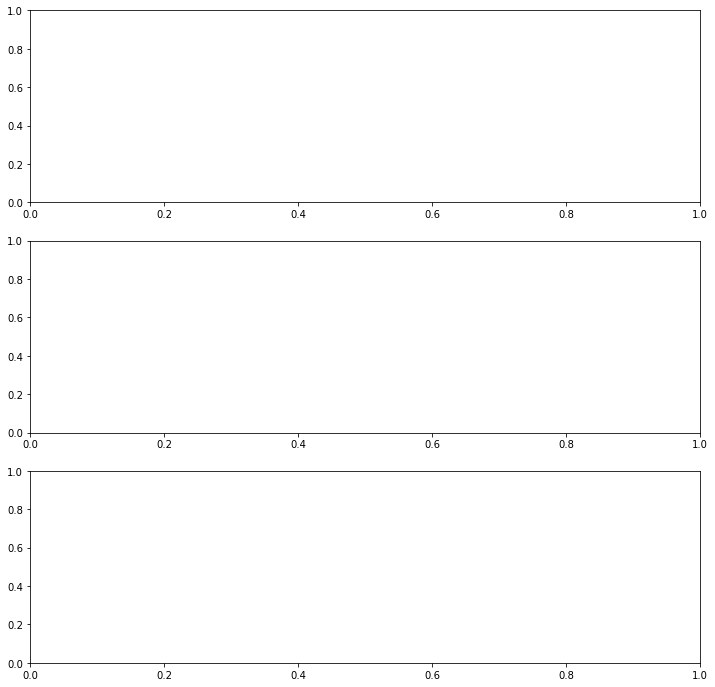

In [13]:
fig,axs = plt.subplots(nrows=3,figsize=(12,12))

X_star = X_posterior[np.argmin(pi_posterior.cpu().numpy())]
pred_star = 2**model(X_star) - 1
V_vals = torch.stack([V_empirical(x,y.T) for x,y in zip(training_.tensors[0],training_.tensors[1])])

for i in range(0,5000,20):
    index = i# np.random.randint(1000)
    pred_opt = 2**model(X_posterior[index]) - 1.
    axs[0].plot(pred_opt[:n_data,2].detach().cpu().numpy(),'k-',alpha=0.02,rasterized=True)
    axs[1].plot(pred_opt[:n_data,1].detach().cpu().numpy(),'k-',alpha=0.02,rasterized=True)
    axs[2].plot(pred_opt[:n_data,0].detach().cpu().numpy(),'k-',alpha=0.02,rasterized=True)
    #axs[2].plot(X_posterior[index,*pred_opt[:n_data,0].detach().cpu().numpy(),'b--',alpha=0.02,rasterized=True)
    
axs[0].plot(test_obs[:n_data].detach().cpu().numpy(),'r:',lw=3.0)
axs[1].plot(pos_obs[:n_data].detach().cpu().numpy(),'r:',lw=3.0)
axs[0].plot(pred_star[:n_data,2].detach().cpu().numpy(),'b--',lw=3.0)
axs[1].plot(pred_star[:n_data,1].detach().cpu().numpy(),'b--',lw=3.0)
axs[2].plot(pred_star[:n_data,0].detach().cpu().numpy(),'b--',lw=3.0)
#axs[2].plot(pred_star[:n_data,0].detach().cpu().numpy(),'b--',lw=3.0)

for idx in torch.sort(V_vals)[1][0:1]:
    best_train = training_.tensors[1][idx].detach().cpu().numpy()
    pred_hat = 2**model(training_.tensors[0][idx]).detach().cpu().numpy()
    axs[0].plot(best_train[2,:n_data],'g-',alpha=0.5)
    axs[1].plot(best_train[1,:n_data],'g-',alpha=0.5)
    axs[2].plot(best_train[0,:n_data],'g-',alpha=0.5)
    axs[0].plot(pred_hat[:n_data,2],'g--',alpha=0.5)
    axs[1].plot(pred_hat[:n_data,1],'g--',alpha=0.5)
    axs[2].plot(pred_hat[:n_data,0],'g--',alpha=0.5)

axs[2].plot(ac[:,0],ac[:,1],'r:',lw=3.0)
axs[2].set_xlim(0,n_data)
axs[1].set_xlim(0,n_data)
axs[0].set_xlim(0,n_data)
axs[2].set_ylim(0,1500)

axs[0].set_ylabel('# Tests')
axs[1].set_ylabel('# Positive')
axs[2].set_ylabel('Active Cases')
axs[2].set_xlabel('Days since 08/19/2020')

fig.savefig('Covid_surrogate_ModelvsObs.pdf')

In [24]:
keys = ['initial_infected_fraction', 'initial_removed_fraction', 'incubation_period', 'serial_interval', 'symptomatic_fraction', 'recovery_days', 'quarantine_days', 'days_indetectable', 'R0', 'contact_rate', 'npi_factor', 'contact_tracing_testing_rate', 'contact_tracing_quarantine_rate', 'contact_tracing_days', 'daily_testing_fraction', 'daily_testing_false_positive', 'daily_testing_false_negative', 'class_size_limit', 'contact_upscale_factor', 'friendship_contacts', 'academic_contacts', 'broad_social_contacts', 'department_environmental_contacts', 'broad_environmental_contacts', 'residential_neighbors', 'online_transition']
X_p_numpy = (X_posterior*X_std + X_mean).detach().cpu().numpy().astype(np.float64)
X_ = training_.tensors[0][idx]
X__numpy = (X_*X_std + X_mean).detach().cpu().numpy()

print(np.round(X__numpy,5))
print(np.round(X_p_numpy.mean(axis=0),5))

[3.64000e-03 3.86300e-02 6.00000e+00 9.00000e+00 2.26900e-01 1.20000e+01
 2.10000e+01 2.00000e+00 4.86497e+00 8.86977e+00 4.67840e-01 8.90440e-01
 1.66929e+00 1.00000e+00 3.70000e-04 9.90000e-04 3.08600e-02 1.47000e+02
 1.17087e+00 4.00000e+00 2.00000e+00 1.00000e+00 5.00000e+00 4.00000e+00
 1.00000e+00 7.50000e+01]
[3.6500000e-03 4.7150000e-02 4.6969000e+00 6.8405600e+00 2.1735000e-01
 1.7352920e+01 1.0335850e+01 2.8176400e+00 3.2663200e+00 1.2497020e+01
 6.8666000e-01 7.6970000e-01 1.0687700e+00 1.0198200e+00 5.2000000e-04
 1.0500000e-03 2.9900000e-02 1.6410318e+02 1.0822600e+00 4.3425400e+00
 3.7431400e+00 2.1145700e+00 3.9530700e+00 3.2773800e+00 8.3100000e-01
 7.2245890e+01]


In [25]:
mean_params = dict(zip(keys,X_p_numpy.mean(axis=0)))
map_train = dict(zip(keys,X__numpy))
#rounded_params = {k: list(np.round(v, 3)) for k, v in mean_params.items()}
import pprint
pprint.pprint(mean_params)
pprint.pprint(map_train)

{'R0': 3.2663166401410573,
 'academic_contacts': 3.7431443935869884,
 'broad_environmental_contacts': 3.2773768297316335,
 'broad_social_contacts': 2.1145743588594597,
 'class_size_limit': 164.10318254189738,
 'contact_rate': 12.4970229943498,
 'contact_tracing_days': 1.019823810525523,
 'contact_tracing_quarantine_rate': 1.0687749043533121,
 'contact_tracing_testing_rate': 0.7697022901585379,
 'contact_upscale_factor': 1.0822615994975175,
 'daily_testing_false_negative': 0.029901540248586437,
 'daily_testing_false_positive': 0.0010469621365826218,
 'daily_testing_fraction': 0.0005187417464872714,
 'days_indetectable': 2.8176440376444973,
 'department_environmental_contacts': 3.953070578778226,
 'friendship_contacts': 4.342539466921984,
 'incubation_period': 4.6968966411414375,
 'initial_infected_fraction': 0.003649599453187783,
 'initial_removed_fraction': 0.04715248595173062,
 'npi_factor': 0.6866602032953585,
 'online_transition': 72.24588752217208,
 'quarantine_days': 10.3358496637

In [26]:
idx

tensor(1273, device='cuda:0')

In [27]:
torch.sort(V_vals)[1][0:1]

tensor([1273], device='cuda:0')

In [18]:
run_abm(map_train)

TypeError: ufunc 'rint' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [7]:
map_train = {'R0': 4.864972,
 'academic_contacts': 1.9999999,
 'broad_environmental_contacts': 4.0,
 'broad_social_contacts': 1.0,
 'class_size_limit': 147.0,
 'contact_rate': 8.86977,
 'contact_tracing_days': 1.0,
 'contact_tracing_quarantine_rate': 1.6692917,
 'contact_tracing_testing_rate': 0.89044154,
 'contact_upscale_factor': 1.1708736,
 'daily_testing_false_negative': 0.030860264,
 'daily_testing_false_positive': 0.0009862408,
 'daily_testing_fraction': 0.00036885968,
 'days_indetectable': 2.0,
 'department_environmental_contacts': 5.0,
 'friendship_contacts': 4.0,
 'incubation_period': 6.0,
 'initial_infected_fraction': 0.0036397844,
 'initial_removed_fraction': 0.038633253,
 'npi_factor': 0.46783707,
 'online_transition': 75.0,
 'quarantine_days': 21.0,
 'recovery_days': 12.0,
 'residential_neighbors': 1.0,
 'serial_interval': 9.0,
 'symptomatic_fraction': 0.22690229}

In [ ]:
def run_abm(run_input):
    run_index,parameters = run_input
    sample = dict(zip(keys,parameters))
    for k in keys_to_round:
        sample[k] = int(np.round(sample[k]))

    sample['scenario_name'] = 'trial_'+str(run_index)
    sample['quarantining'] = 1
    sample['social_distancing'] = 1
    sample['contact_tracing'] = 1

    pandemic = pan.Disease(sample)
    pandemic.multiple_runs(5,recorder)

In [8]:
    recorder = pan.analysis.recorder(['tests_performed_total', 'positive_tests_total', 'active_cases'], 
                                     './optim_large.h5')

In [9]:
map_train['scenario_name'] = 'trial_optim'

In [10]:
    map_train['quarantining'] = 1
    map_train['social_distancing'] = 1
    map_train['contact_tracing'] = 1
    for k in keys_to_round:
        map_train[k] = int(np.round(map_train[k]))

In [11]:
pandemic = pan.Disease(map_train)

{'quarantining': 1, 'contact_tracing': 1, 'initial_infected_fraction': 0.0036397844, 'initial_removed_fraction': 0.038633253, 'removed_cohorts': [], 'incubation_period': 6, 'serial_interval': 9, 'symptomatic_fraction': 0.22690229, 'recovery_days': 12, 'quarantine_days': 21, 'days_indetectable': 2, 'R0': 4.864972, 'contact_rate': 8.86977, 'npi_factor': 0.46783707, 'daily_outside_cases': [1, 0, 0, 0], 'contact_tracing_testing_rate': 0.89044154, 'contact_tracing_quarantine_rate': 1.6692917, 'contact_tracing_days': 1, 'daily_testing_fraction': 0.00036885968, 'daily_testing_false_positive': 0.0009862408, 'daily_testing_false_negative': 0.030860264}
+++++ Presymptomatic Transmission: 0.24649826882493875
+++++ Attack Rate:  0.392443823872263
+++++ SD_BEFOR:   2432    53673    2486464
+++++ SD_AFTER:   2307    40515    1056214
+++++ SD_WEIGH:   2235    36762     857859
+++++ Activity Reduction: 0.7548  Crowd Reduction: 0.8122
+++++ Active on Day 0 : 22362
+++++ Active on Day 1 : 16344
+++++ Ac

In [12]:
pandemic.multiple_runs(25,recorder)

+++++ SD_BEFOR:   2435    53455    2428210
+++++ SD_AFTER:   2318    41214    1104988
+++++ SD_WEIGH:   2254    37733     912357
+++++ Activity Reduction: 0.7710  Crowd Reduction: 0.8257
+++++ Active on Day 0 : 23048
+++++ Active on Day 1 : 16492
+++++ Active on Day 2 : 22741
+++++ Active on Day 3 : 16473
+++++ Active on Day 4 : 16605
+++++ SD_BEFOR:   2445    53896    2436718
+++++ SD_AFTER:   2328    41643    1100398
+++++ SD_WEIGH:   2260    38034     904174
+++++ Activity Reduction: 0.7727  Crowd Reduction: 0.8217
+++++ Active on Day 0 : 24093
+++++ Active on Day 1 : 15479
+++++ Active on Day 2 : 23860
+++++ Active on Day 3 : 15777
+++++ Active on Day 4 : 16836
+++++ SD_BEFOR:   2404    53157    2426162
+++++ SD_AFTER:   2290    41042    1090846
+++++ SD_WEIGH:   2227    37643     904375
+++++ Activity Reduction: 0.7721  Crowd Reduction: 0.8291
+++++ Active on Day 0 : 22948
+++++ Active on Day 1 : 16568
+++++ Active on Day 2 : 23133
+++++ Active on Day 3 : 16161
+++++ Active on Day

In [3]:
newset = hdf5Dataset_init('optim_large.h5')   
train_new, test_new = newset.split_datasets(0.1,split_type='parameter')

25


IndexError: list index out of range

In [25]:
tests_total = recorder.values['tests_performed_total']['all_runs']
pos_total = recorder.values['positive_tests_total']['all_runs']

In [4]:
recorder.values

NameError: name 'recorder' is not defined

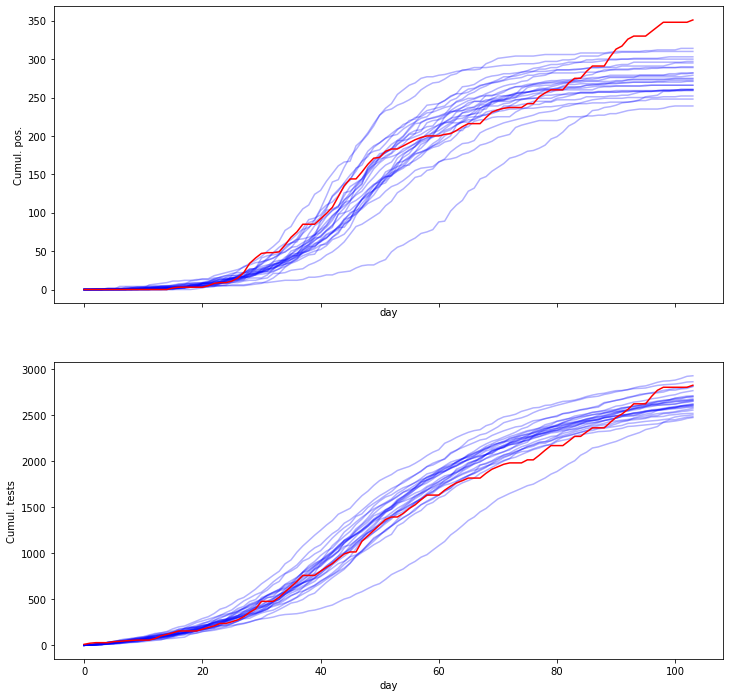

In [27]:
fig,axs = plt.subplots(nrows=2,sharex=True)
fig.set_size_inches(12,12)
[axs[0].plot(pos_total[i,:len(pos_obs)],'b-',alpha=0.3) for i in range(25)]
axs[0].plot(pos_obs.cpu().numpy(),'r-')
axs[0].set_xlabel('day')
axs[0].set_ylabel('Cumul. pos.')
[axs[1].plot(tests_total[i,:len(pos_obs)],'b-',alpha=0.3) for i in range(25)]
axs[1].plot(test_obs.cpu().numpy(),'r-')
axs[1].set_xlabel('day')
axs[1].set_ylabel('Cumul. tests')
fig.savefig('abm_vs_data.pdf')

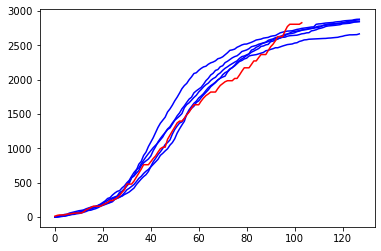